In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (30,5)
plt.rcParams['figure.dpi'] = 250
sns.set_style('darkgrid')
%matplotlib inline

# Data Preparation and Exploration

In [3]:
df = pd.read_csv("exchange_rate.csv")
df.head()

,date,Ex_rate
0,01-01-1990 00:00,0.7855
1,02-01-1990 00:00,0.7818
2,03-01-1990 00:00,0.7867
3,04-01-1990 00:00,0.7860
4,05-01-1990 00:00,0.7849


In [4]:
df = pd.read_csv("exchange_rate.csv")
df["date"] = pd.to_datetime(df["date"], format="%d-%m-%Y %H:%M")
df = df.set_index("date").sort_index()
df

,Ex_rate
date,
1990-01-01,0.785500
1990-01-02,0.781800
1990-01-03,0.786700
1990-01-04,0.786000
1990-01-05,0.784900
...,...
2010-10-06,0.718494
2010-10-07,0.721839
2010-10-08,0.723197


In [5]:
y = df["Ex_rate"]   
y

date
1990-01-01    0.785500
1990-01-02    0.781800
1990-01-03    0.786700
1990-01-04    0.786000
1990-01-05    0.784900
                ...   
2010-10-06    0.718494
2010-10-07    0.721839
2010-10-08    0.723197
2010-10-09    0.720825
2010-10-10    0.720825
Name: Ex_rate, Length: 7588, dtype: float64

In [6]:
df.head(7588)

,Ex_rate
date,
1990-01-01,0.785500
1990-01-02,0.781800
1990-01-03,0.786700
1990-01-04,0.786000
1990-01-05,0.784900
...,...
2010-10-06,0.718494
2010-10-07,0.721839
2010-10-08,0.723197


In [7]:
df.shape

(7588, 1)

In [8]:
df.dtypes

Ex_rate    float64
dtype: object

In [9]:
df.isnull().sum()

Ex_rate    0
dtype: int64

In [10]:
df.describe()

,Ex_rate
count,7588.000000
mean,0.776974
std,0.136620
min,0.483297
25%,0.701422
50%,0.761377
75%,0.873477
max,1.102536


In [11]:
df.duplicated().sum()

np.int64(2258)

In [12]:

df['Ex_rate']

date
1990-01-01    0.785500
1990-01-02    0.781800
1990-01-03    0.786700
1990-01-04    0.786000
1990-01-05    0.784900
                ...   
2010-10-06    0.718494
2010-10-07    0.721839
2010-10-08    0.723197
2010-10-09    0.720825
2010-10-10    0.720825
Name: Ex_rate, Length: 7588, dtype: float64

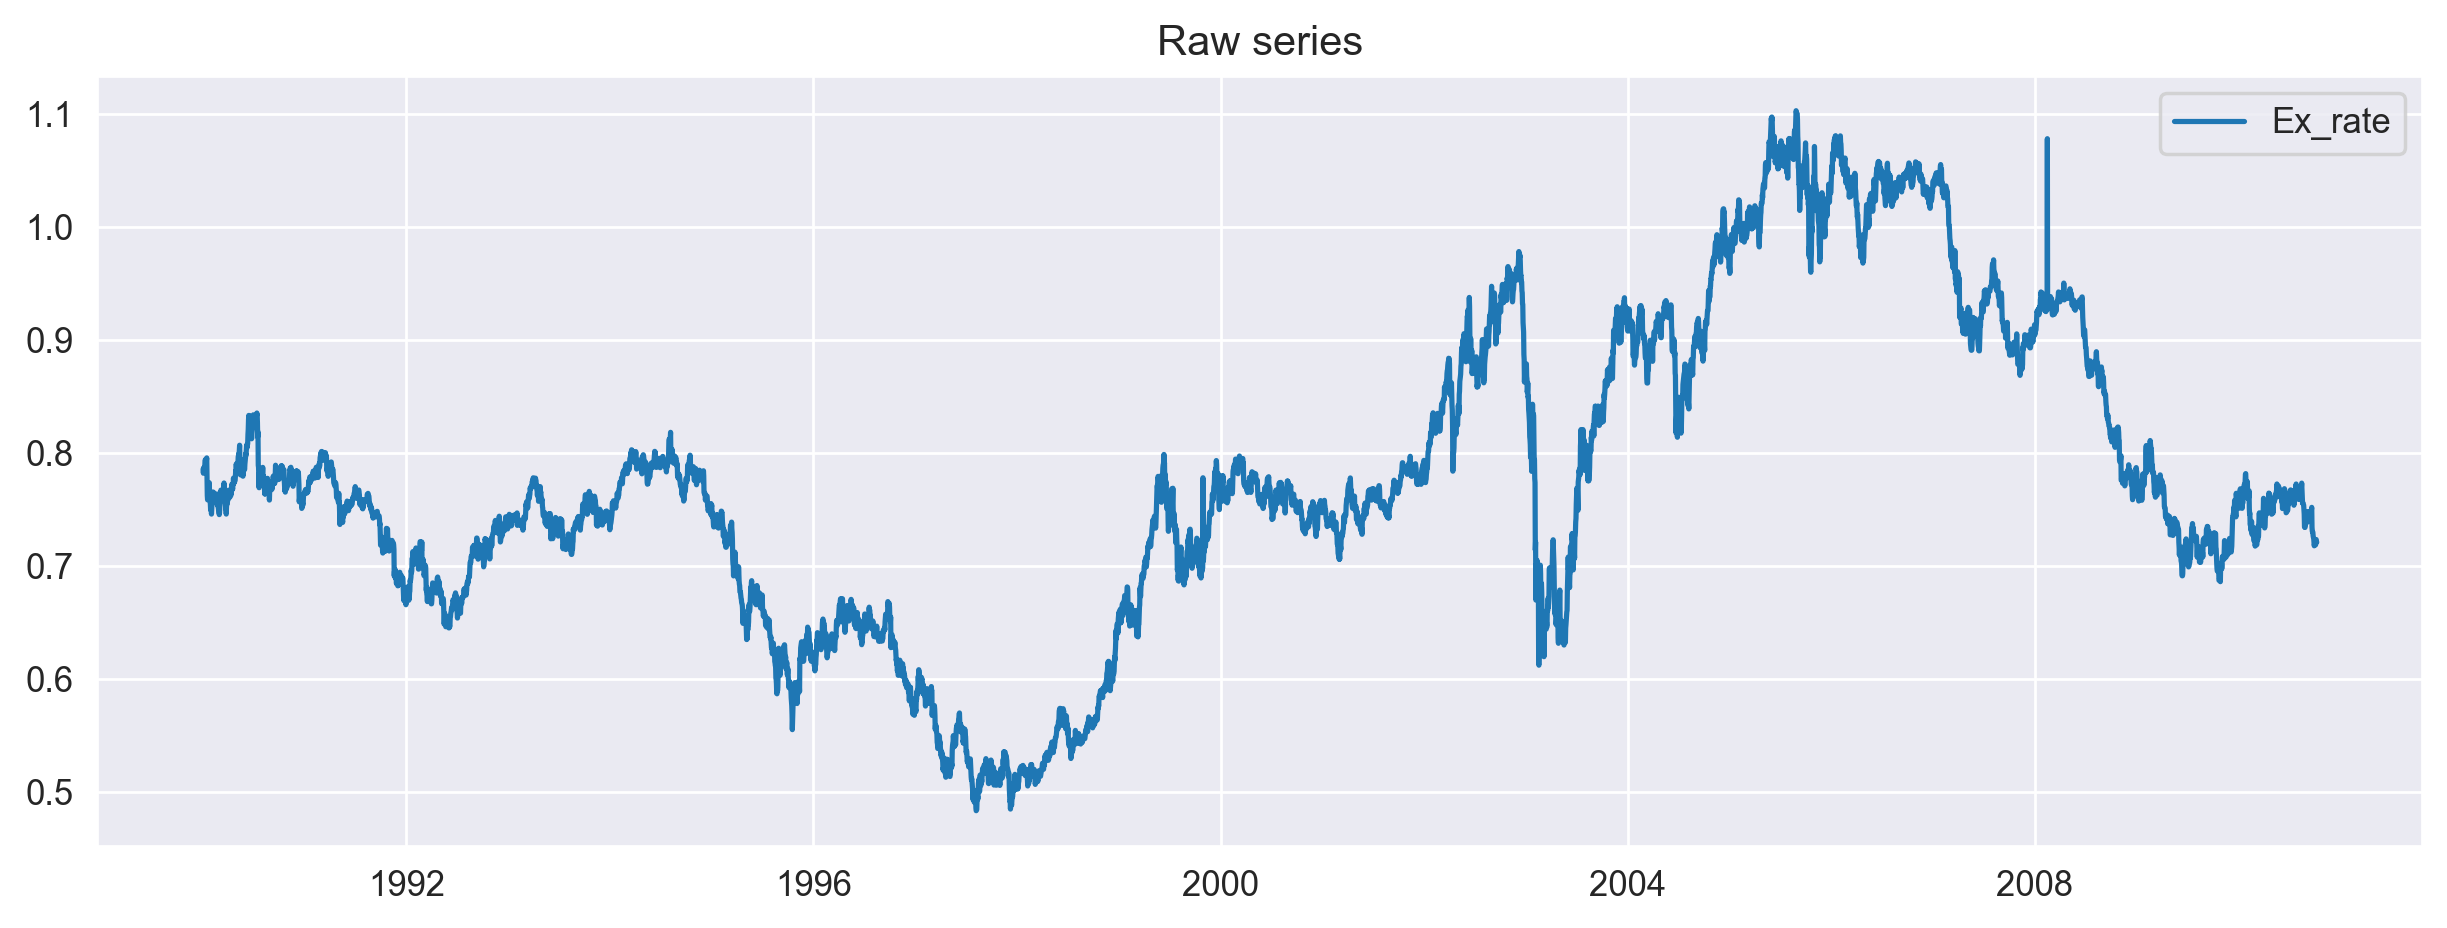

In [13]:
plt.figure(figsize=(12,4))
plt.plot(y, label="Ex_rate")
plt.title("Raw series")
plt.legend(); plt.show()

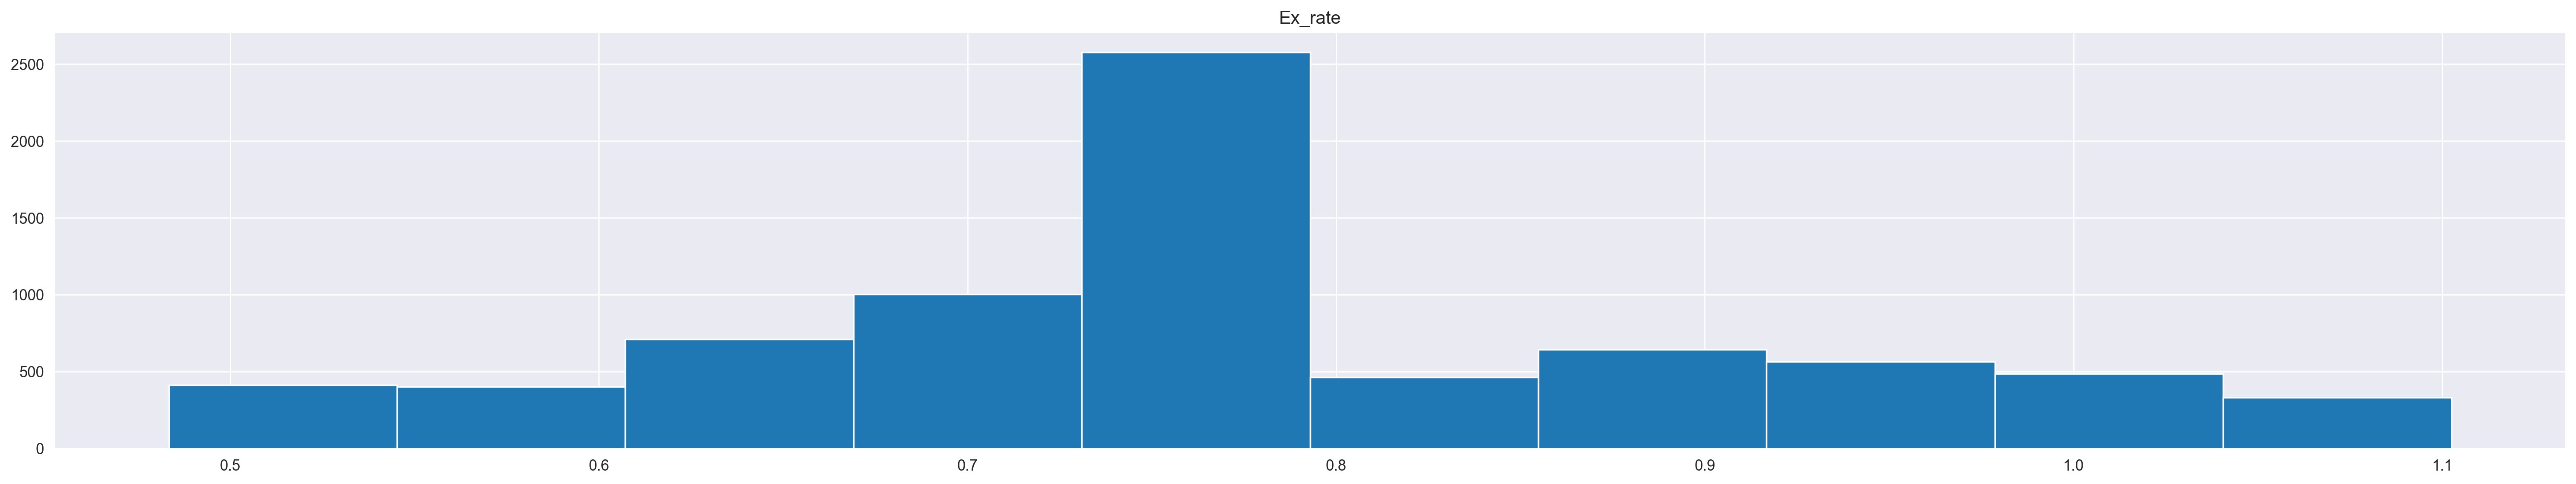

In [14]:
df.hist()
plt.show()

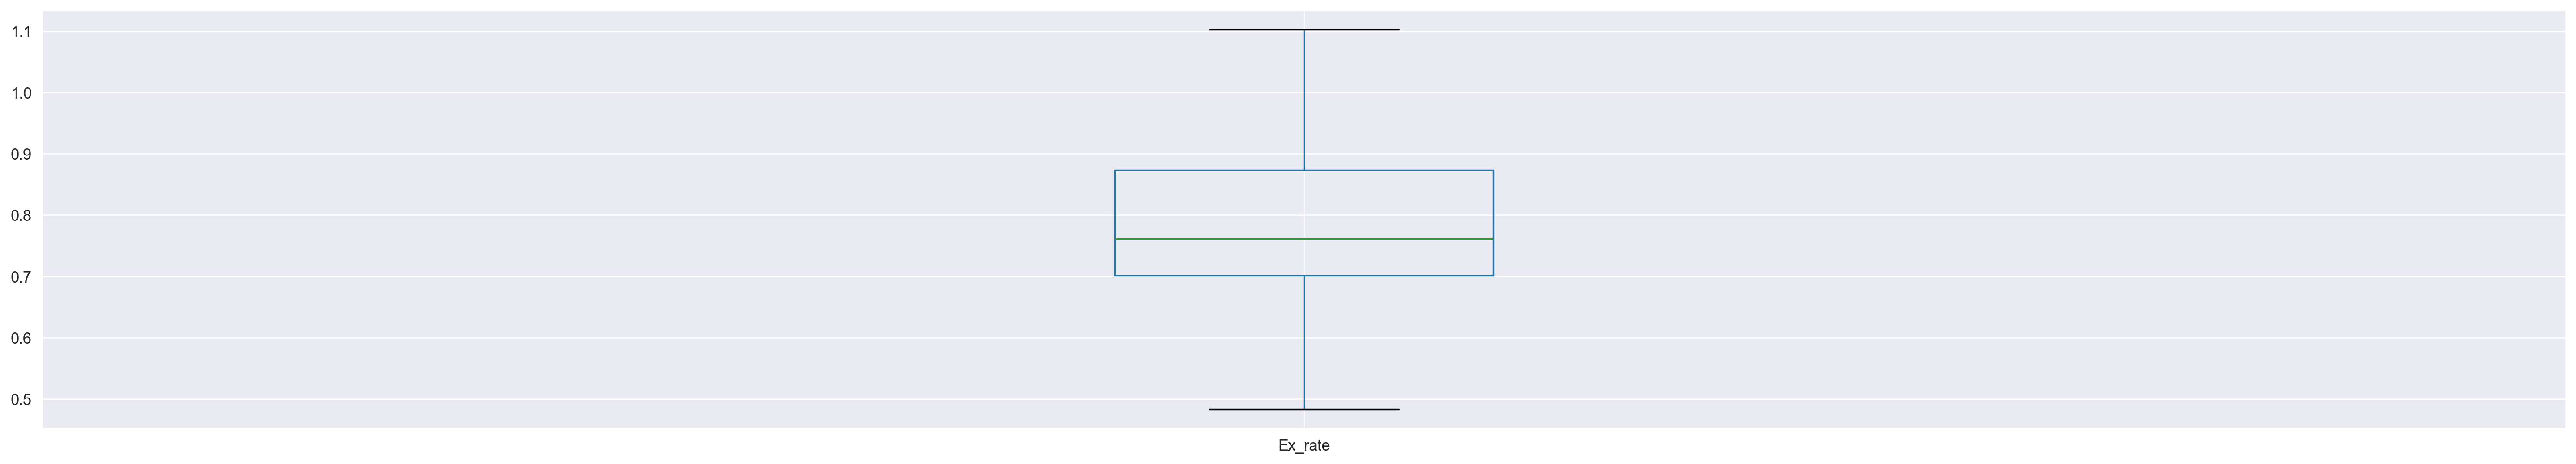

In [15]:
df.boxplot()
plt.show()

Key observations:

Trend present: Periods of increase (e.g., around index 3000–6000) and decrease (e.g., around index 2000 and 7000).

Non-stationary: Both mean and variance change with time.

No clear seasonality: The pattern does not repeat regularly.

In [16]:
adfuller(y)[1]

np.float64(0.4492327353597901)

Null hypothesis: Data is Non stationary

Alternate Hypothesis: Data is Stationary

If p< 0.05 ; Data is stationary

if p>0.05; Data is not stationary

According the p-value, the dataset is not stationary as the p value greter than alpha value.

- We checked rolling mean & std
- Then performed ADF test
- Series became stationary after differencing once (d=1)


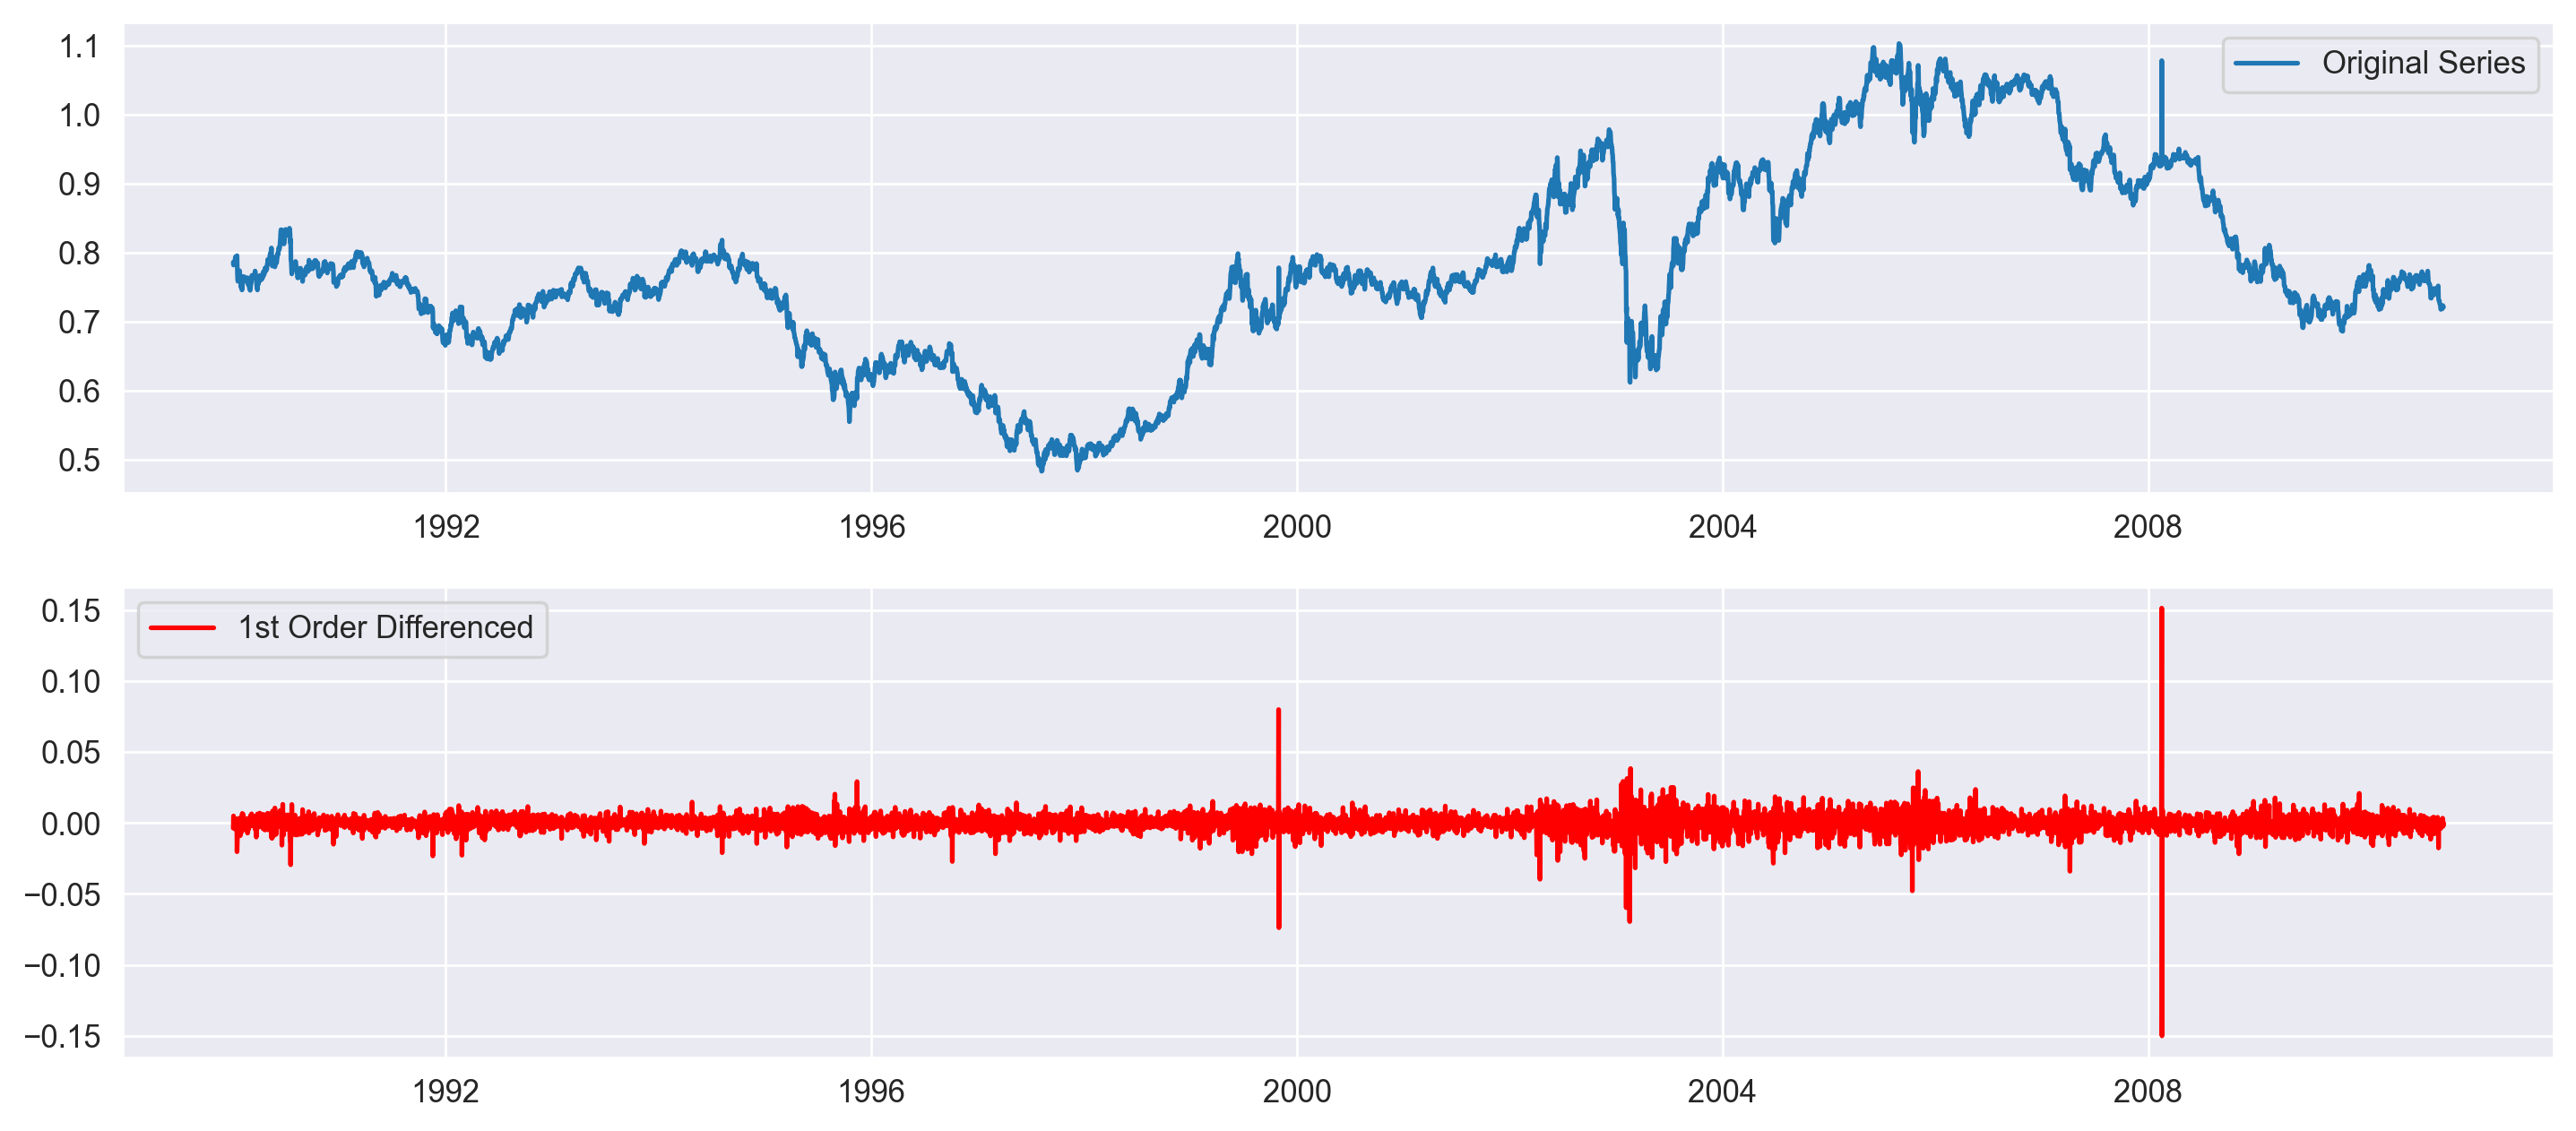

In [17]:
# 1st order differencing
y_diff = y.diff().dropna()

# plot original vs differenced
plt.figure(figsize=(14,6))
plt.subplot(211)
plt.plot(y, label="Original Series")
plt.legend(loc="best")
plt.subplot(212)
plt.plot(y_diff, label="1st Order Differenced", color="red")
plt.legend(loc="best")
plt.show()


In [18]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(y_diff)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

if result[1] <= 0.05:
    print(" Series is Stationary")
else:
    print(" Series is NOT Stationary")


ADF Statistic: -99.39343120118629
p-value: 0.0
 Series is Stationary


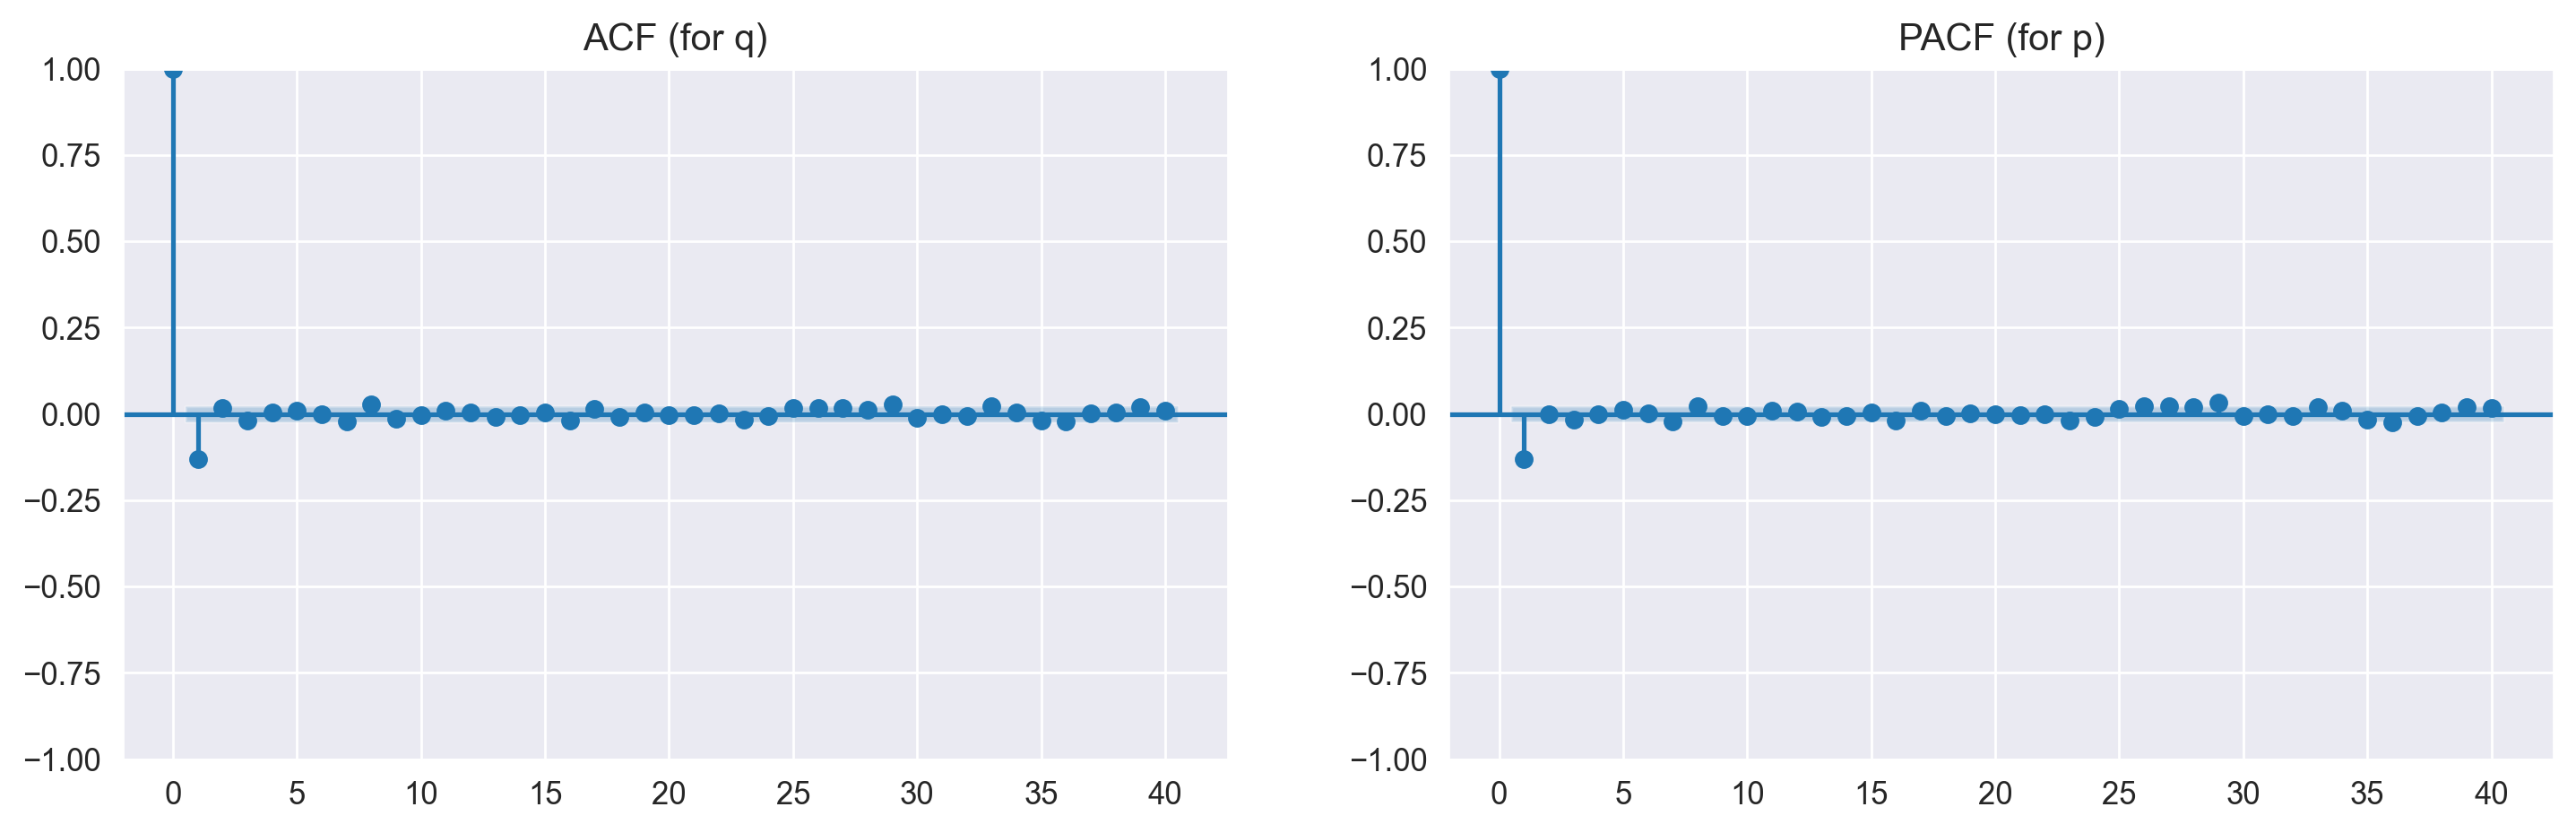

In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(14,4))

plot_acf(y_diff, lags=40, ax=axes[0])
axes[0].set_title("ACF (for q)")

plot_pacf(y_diff, lags=40, ax=axes[1], method="ywm")
axes[1].set_title("PACF (for p)")

plt.show()


 - ACF significant at lag 1 → suggests MA(1)
 - PACF significant at lag 1 → suggests AR(1)
 -Therefore, p=1, d=1, q=1 → ARIMA(1,1,1)


###############################################################################################

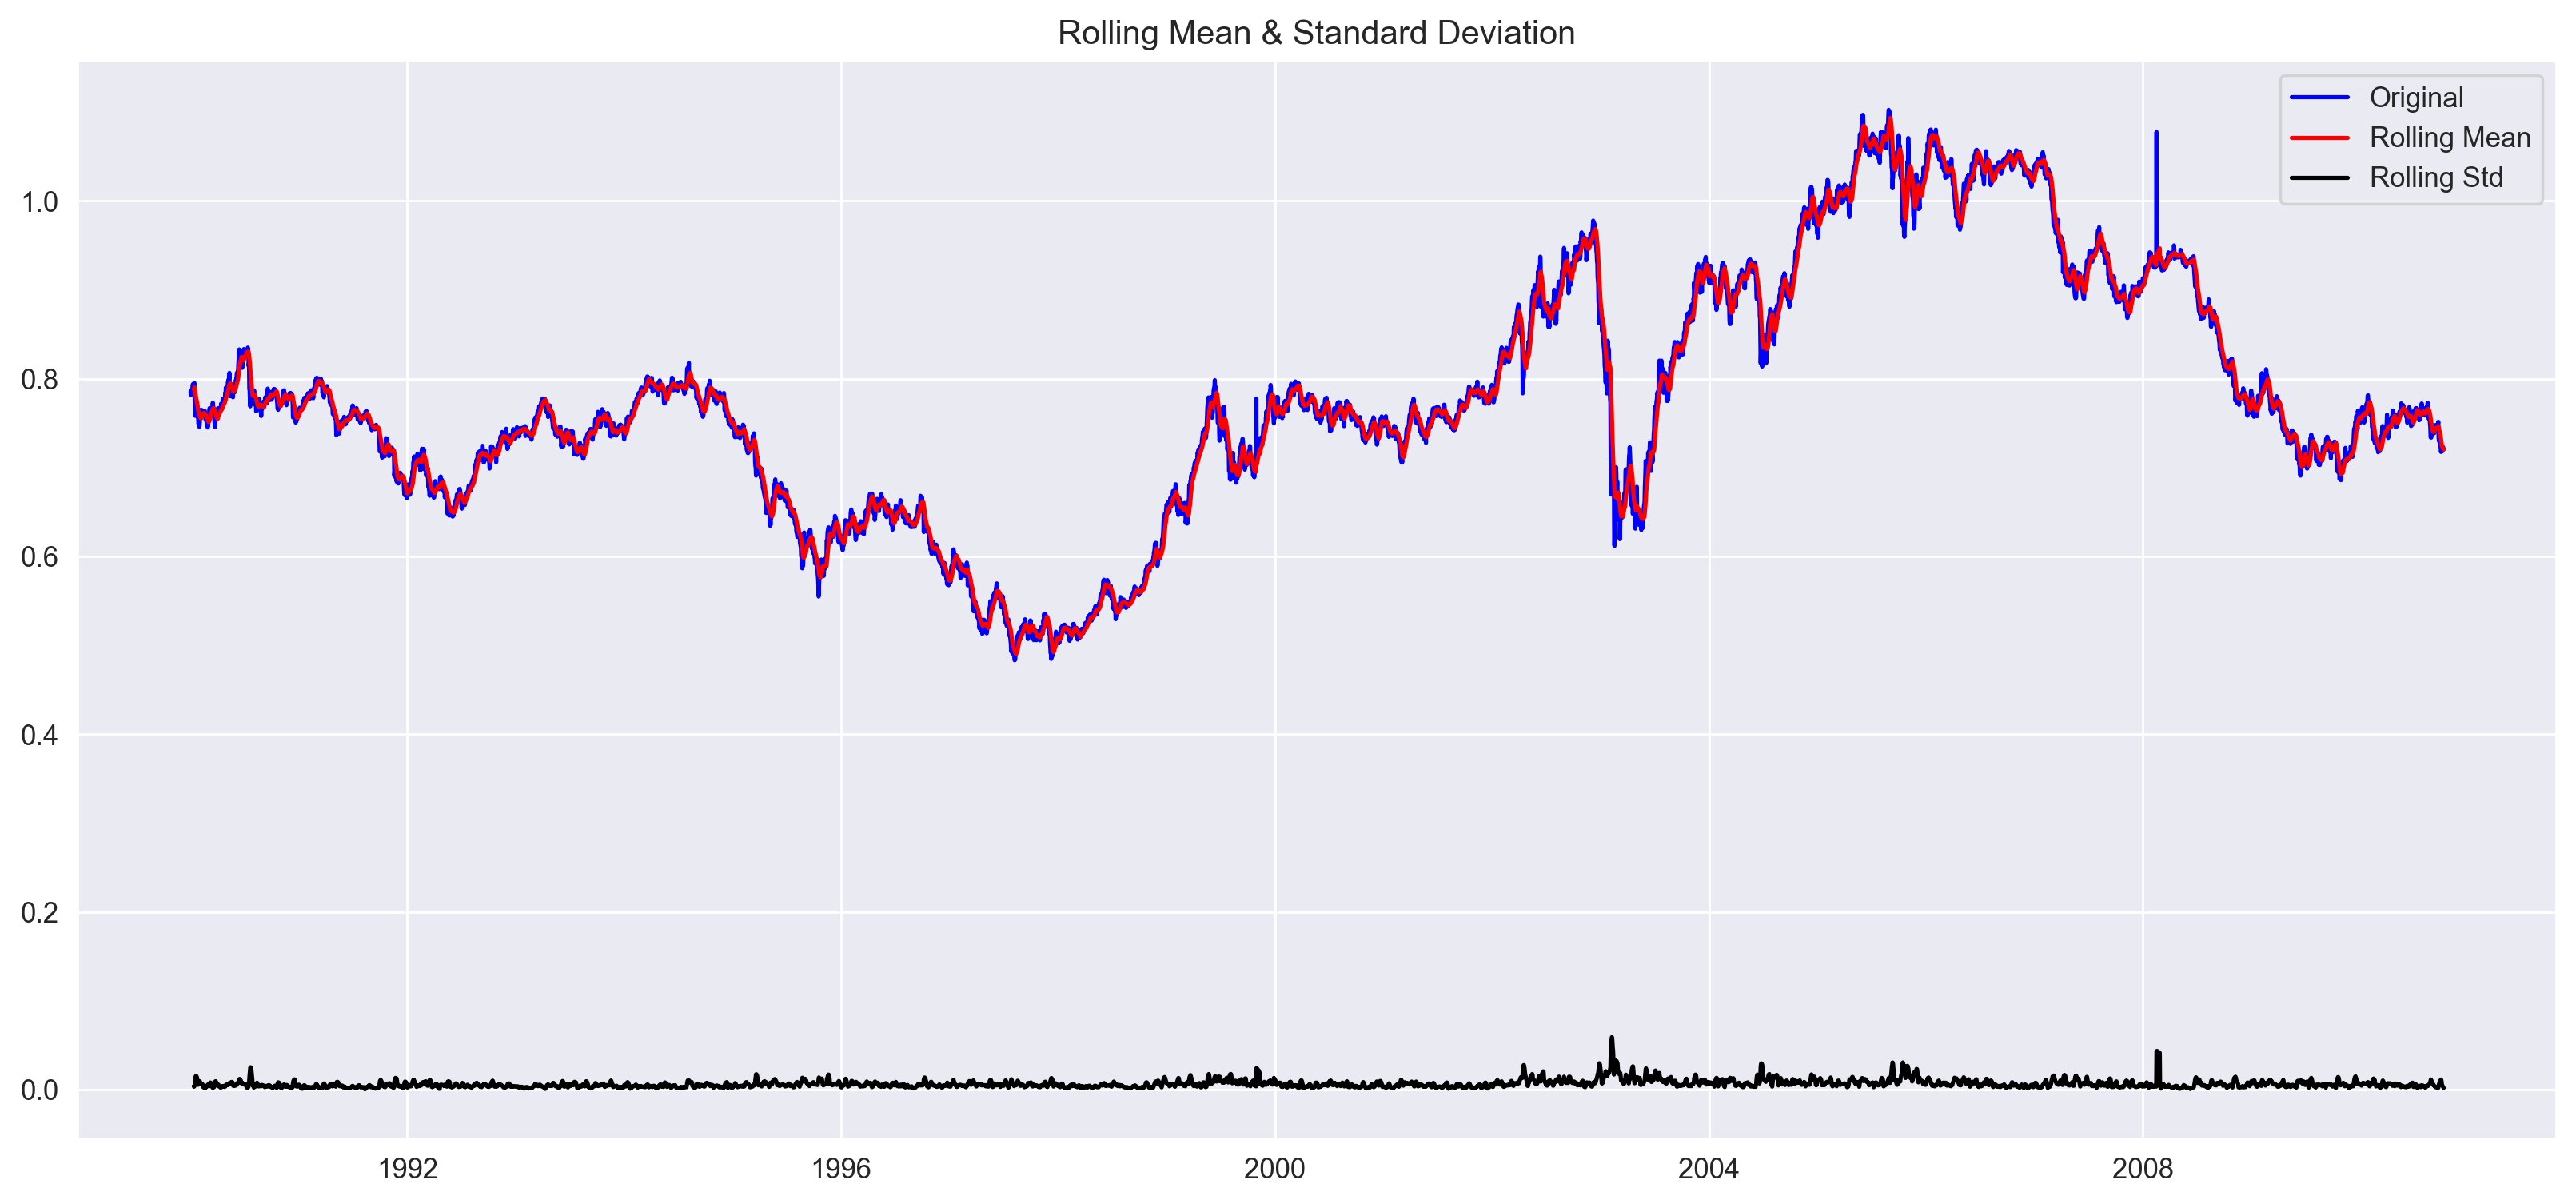

In [28]:
# Rolling statistics
rolLmean = df['Ex_rate'].rolling(12).mean()   # 12 points rolling mean
rolLstd  = df['Ex_rate'].rolling(12).std()    # 12 points rolling std

plt.figure(figsize=(16,7))

# Plot original
plt.plot(df['Ex_rate'], color='blue', label='Original')

# Plot rolling mean & std
plt.plot(rolLmean, color='red', label='Rolling Mean')
plt.plot(rolLstd, color='black', label='Rolling Std')

plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()


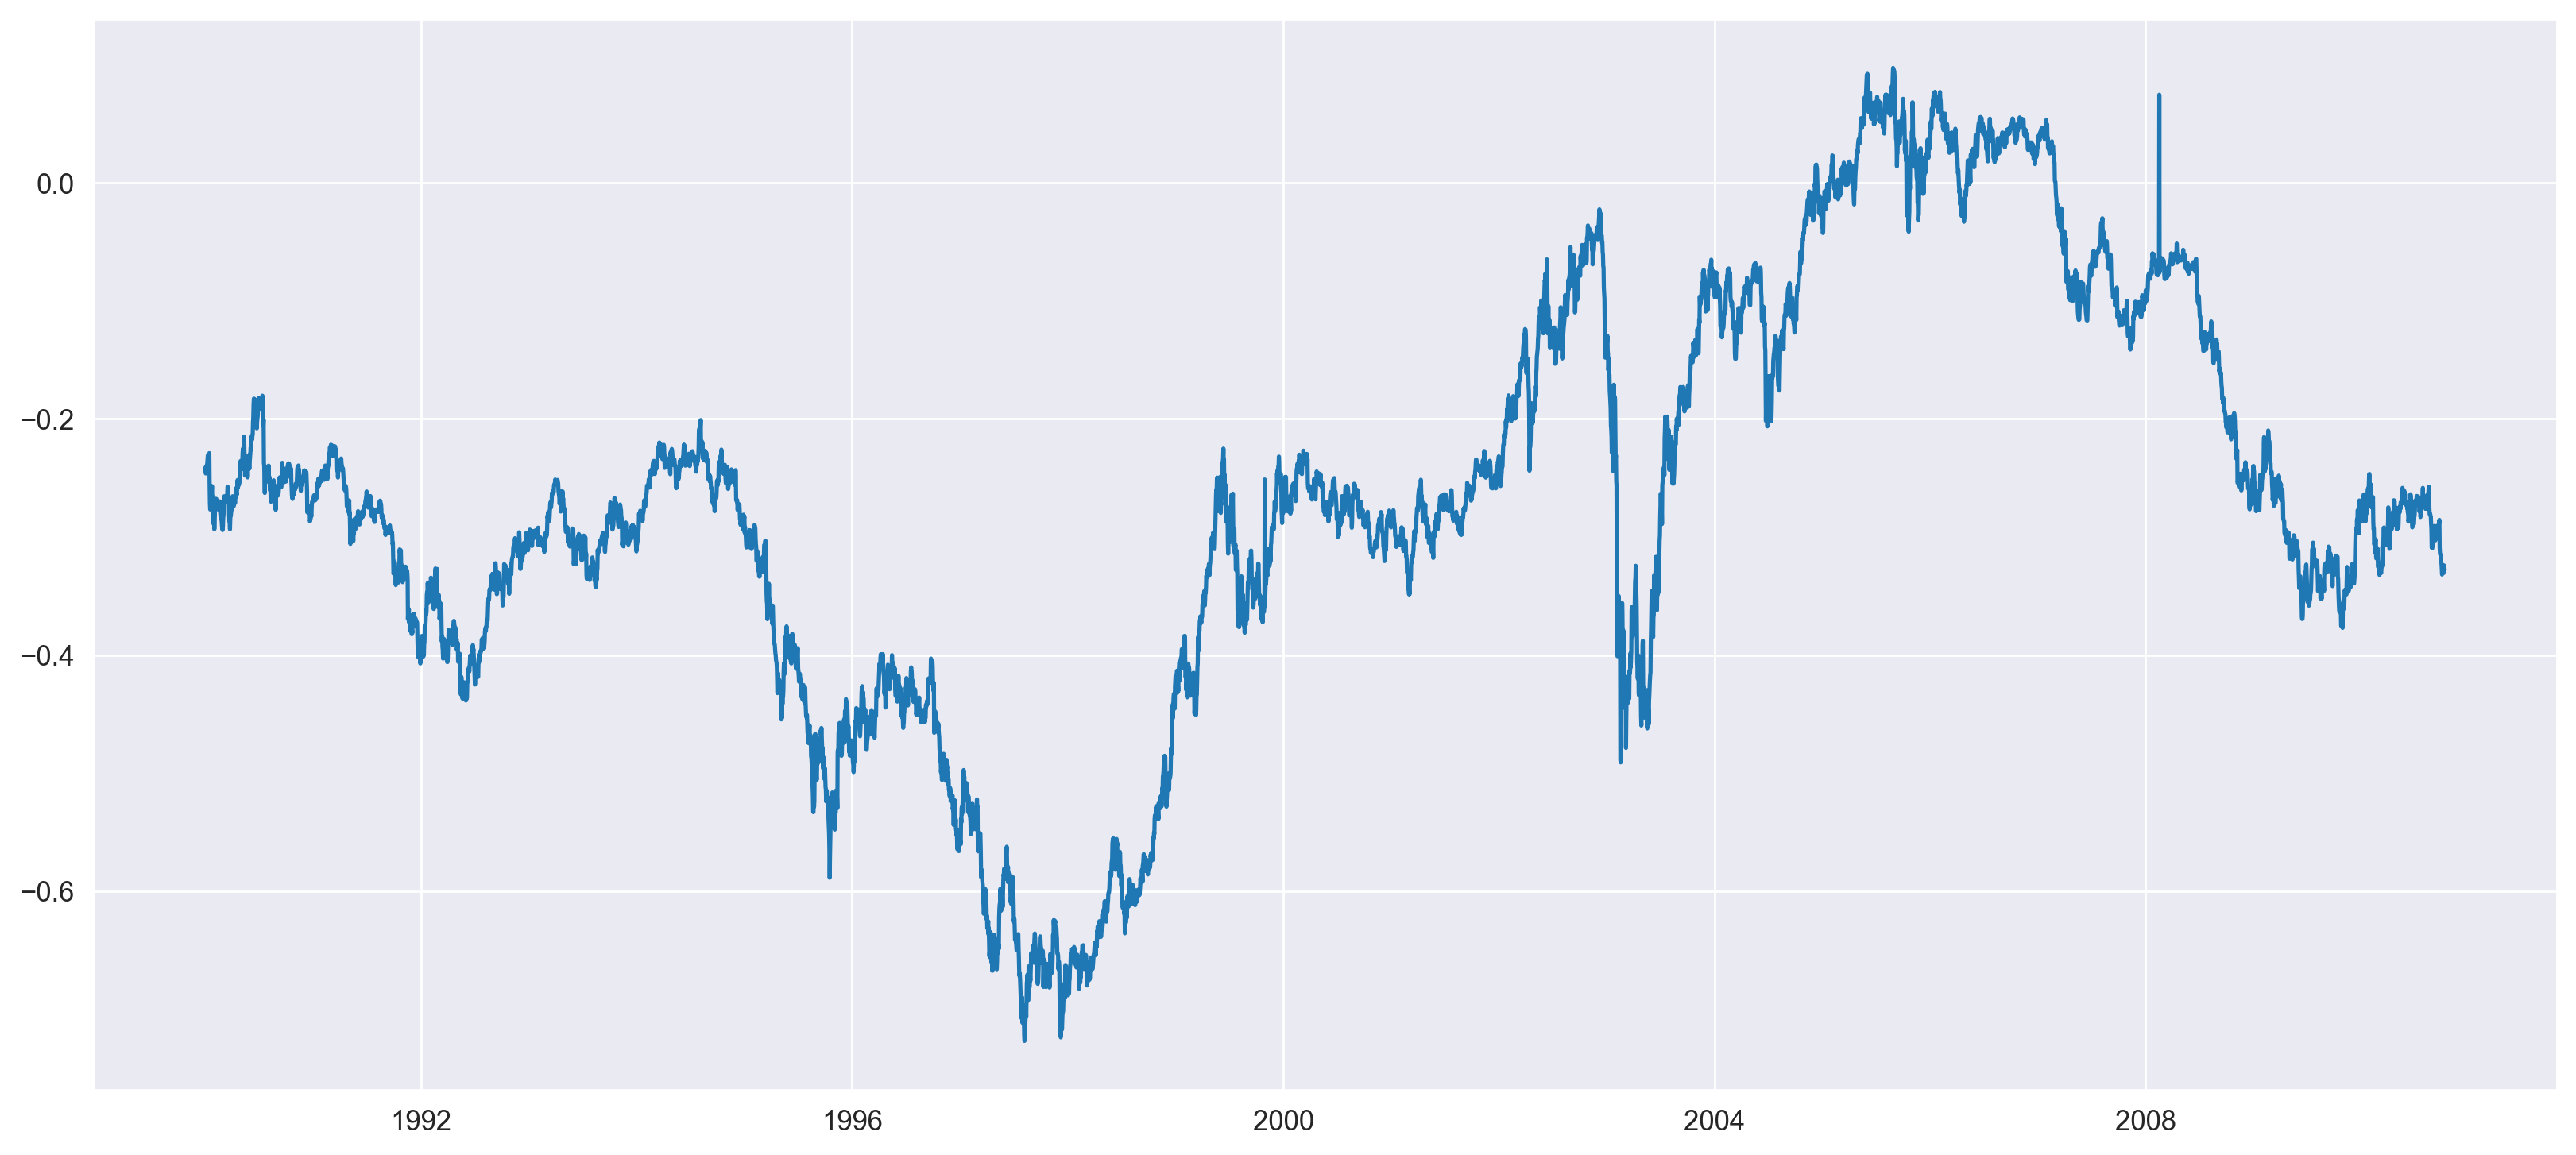

In [29]:
plt.figure(figsize=(16,7))
fig = plt.figure(1)

import numpy as np
ts_log = np.log(df)#to transformfrom non-stationary  to stationary 
plt.plot(ts_log)
plt.show()

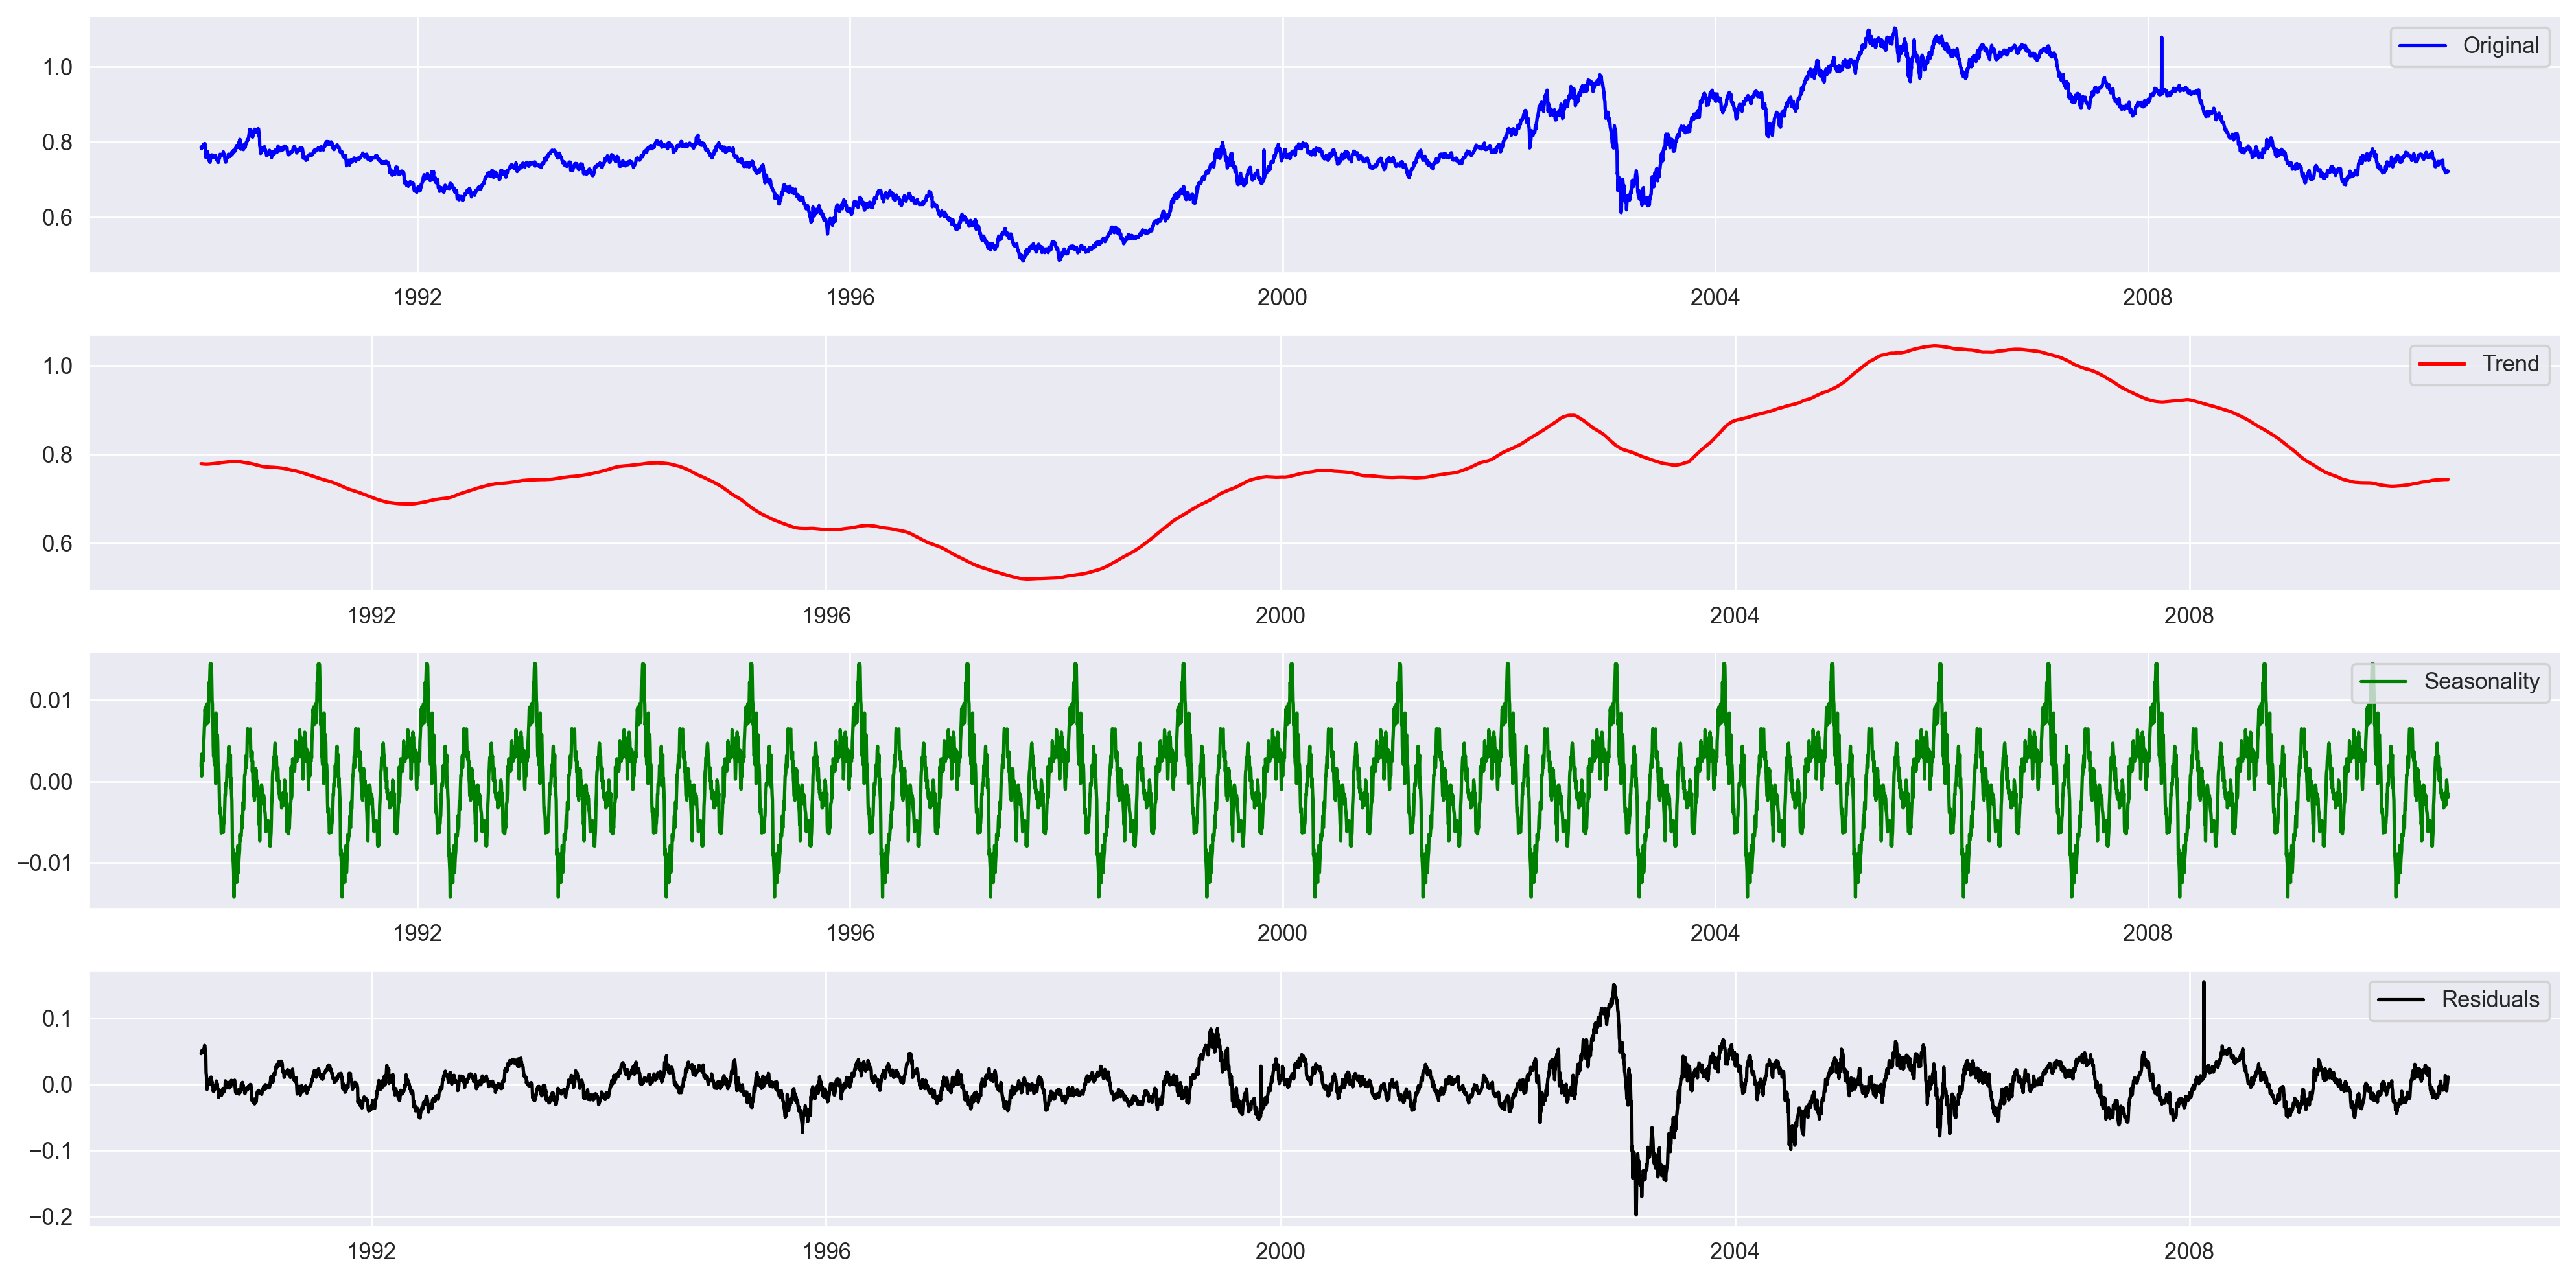

In [30]:
from statsmodels.tsa.seasonal import seasonal_decompose


decomposition = seasonal_decompose(df['Ex_rate'], model='additive', period=365)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(16,8))

plt.subplot(411)
plt.plot(df['Ex_rate'], label='Original', color="blue")
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend', color="red")
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="green")
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals', color="black")
plt.legend(loc='best')

plt.tight_layout()
plt.show()


Make Series Stationary

In [42]:
diff_series= df['Ex_rate'].diff().dropna() # it is 1st step differencing (trend is present in data)


In [35]:
result = adfuller(df['Ex_rate'].dropna())
print("p-value:", result[1])

p-value: 0.4492327353597901


p value become 0.0 means my data is stationary data

#########################################################################################

# Model Building - ARIMA

ACF & PACF

In [45]:

# Fit the ARIMA model
model_arima = ARIMA(df['Ex_rate'], order=(1,1,1))
result_arima = model_arima.fit()

# Summary of the model
print(result_arima.summary())


                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Wed, 17 Sep 2025   AIC                         -56102.322
Time:                        07:53:50   BIC                         -56081.519
Sample:                    01-01-1990   HQIC                        -56095.182
                         - 10-10-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.604      0.0

We used the ARIMA model from statsmodels, specifying the parameters (p=1, d=1, q=1) and fitted it on the exchange rate data. The summary output provides coefficients, statistical significance, and goodness-of-fit metrics.

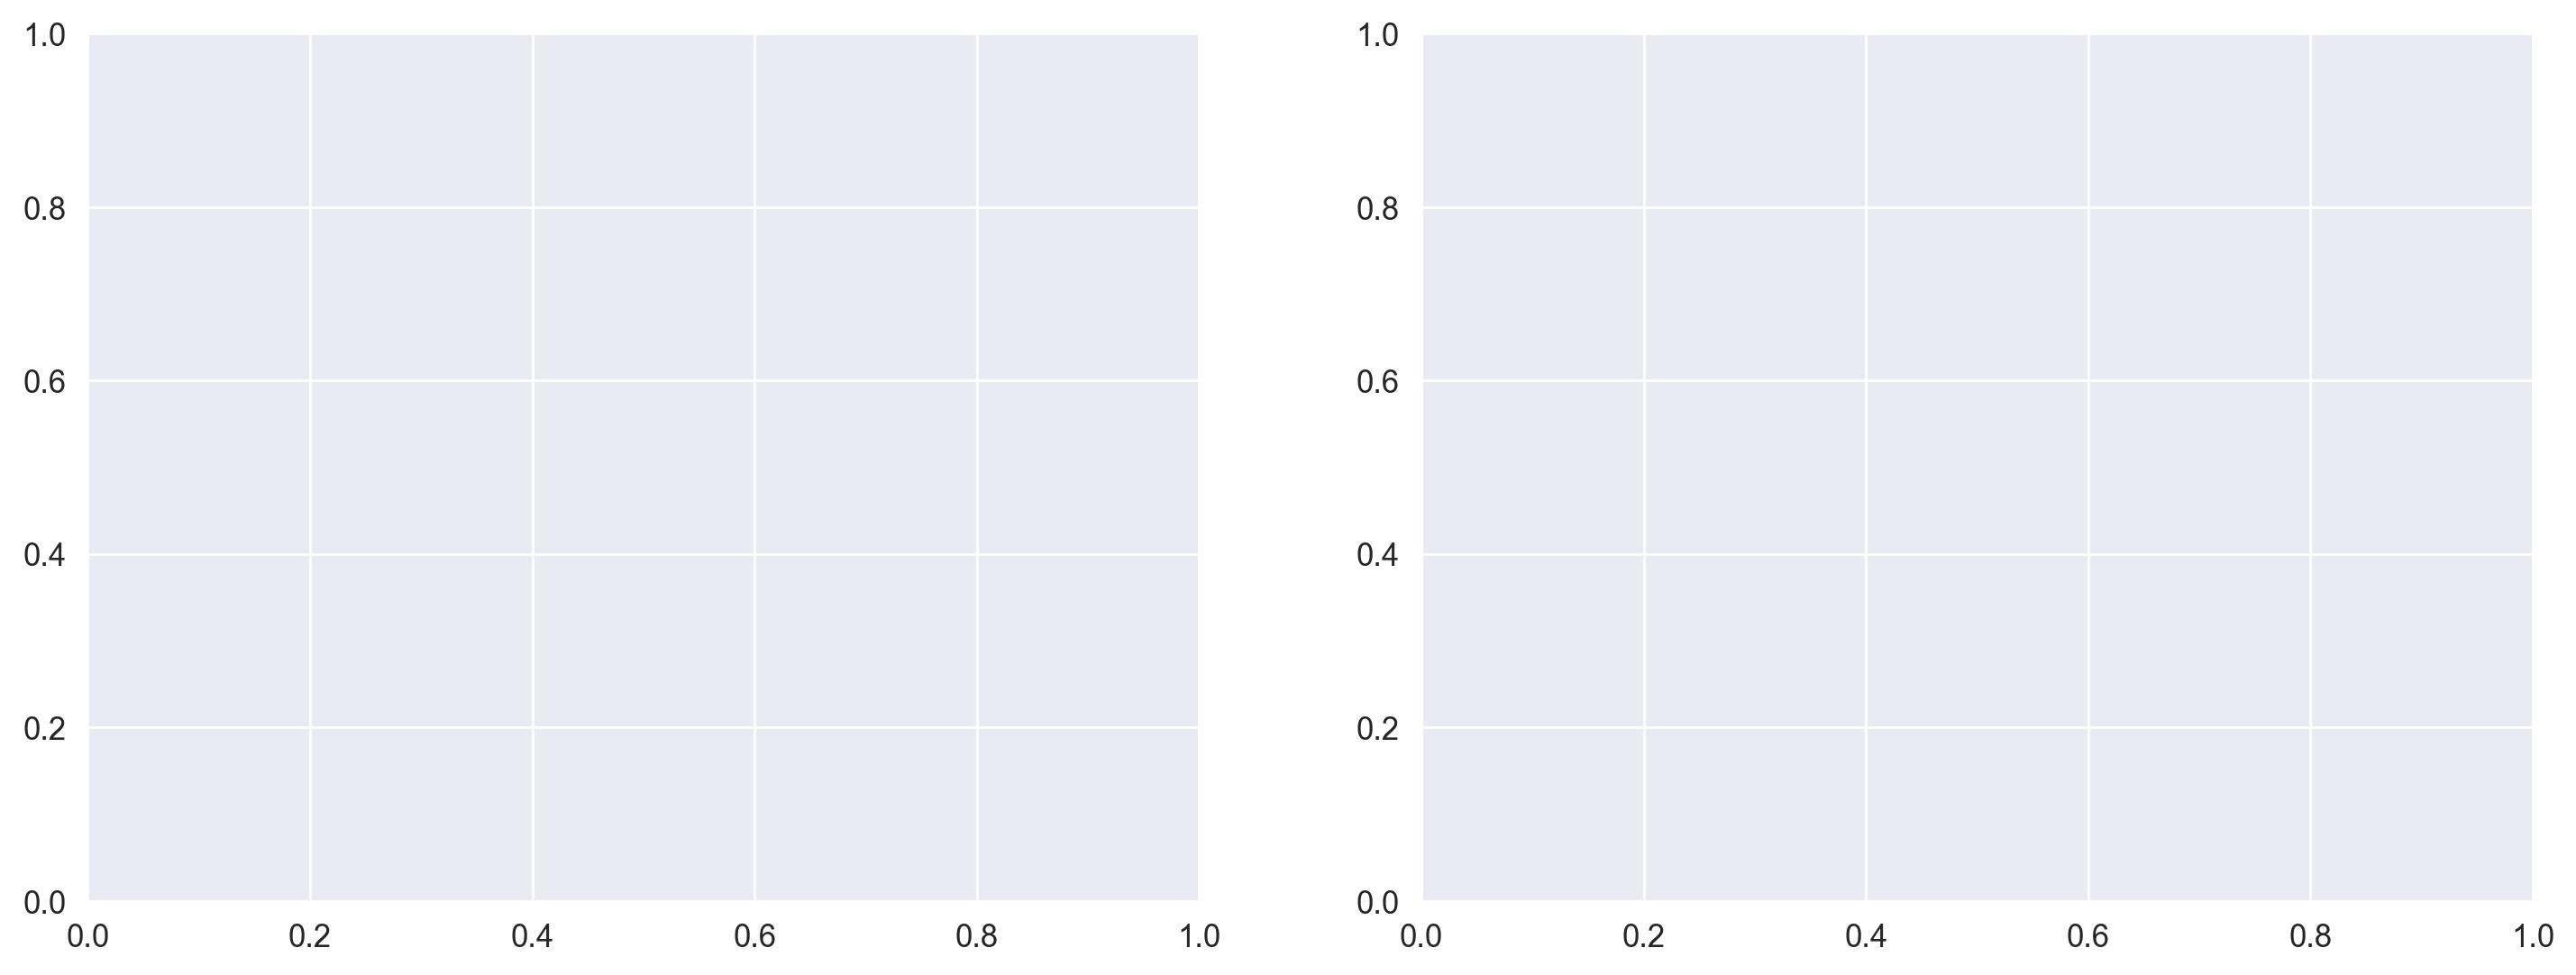

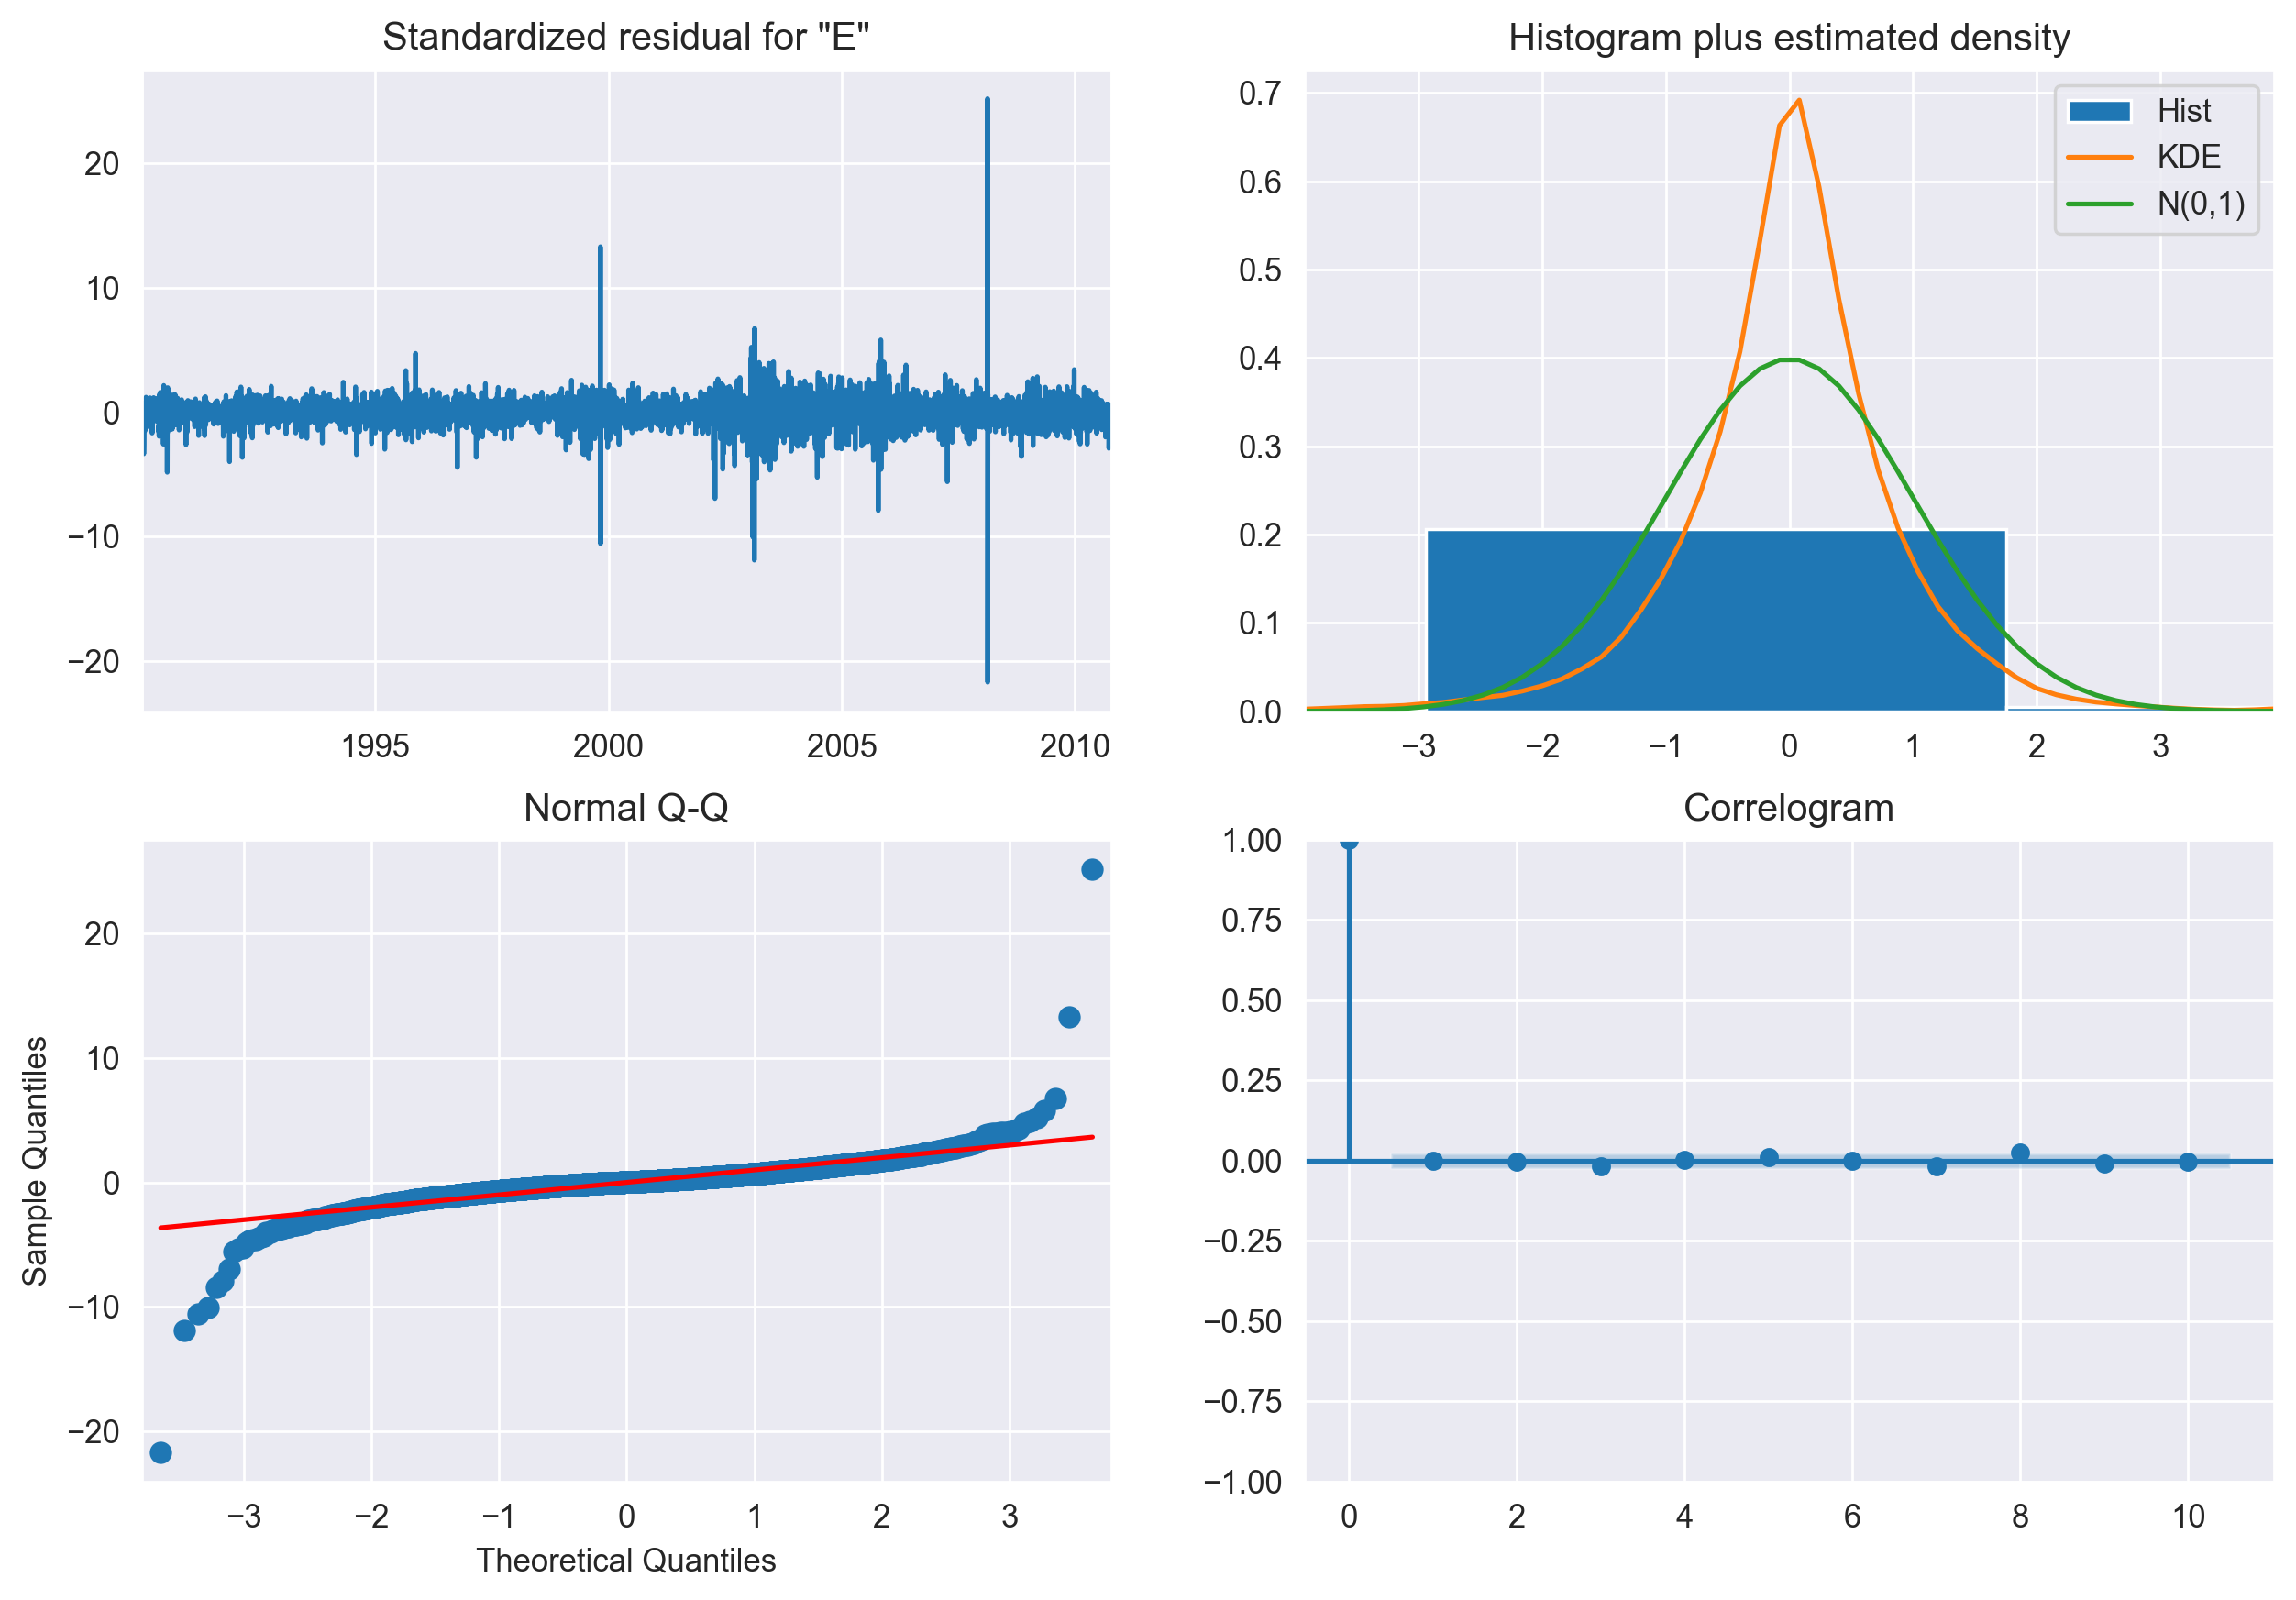

In [46]:
result_arima.plot_diagnostics(figsize=(12,8))
plt.show()


This plot helps in verifying that the residuals behave like white noise — no patterns or correlations should remain after modeling

<Figure size 3000x1500 with 0 Axes>

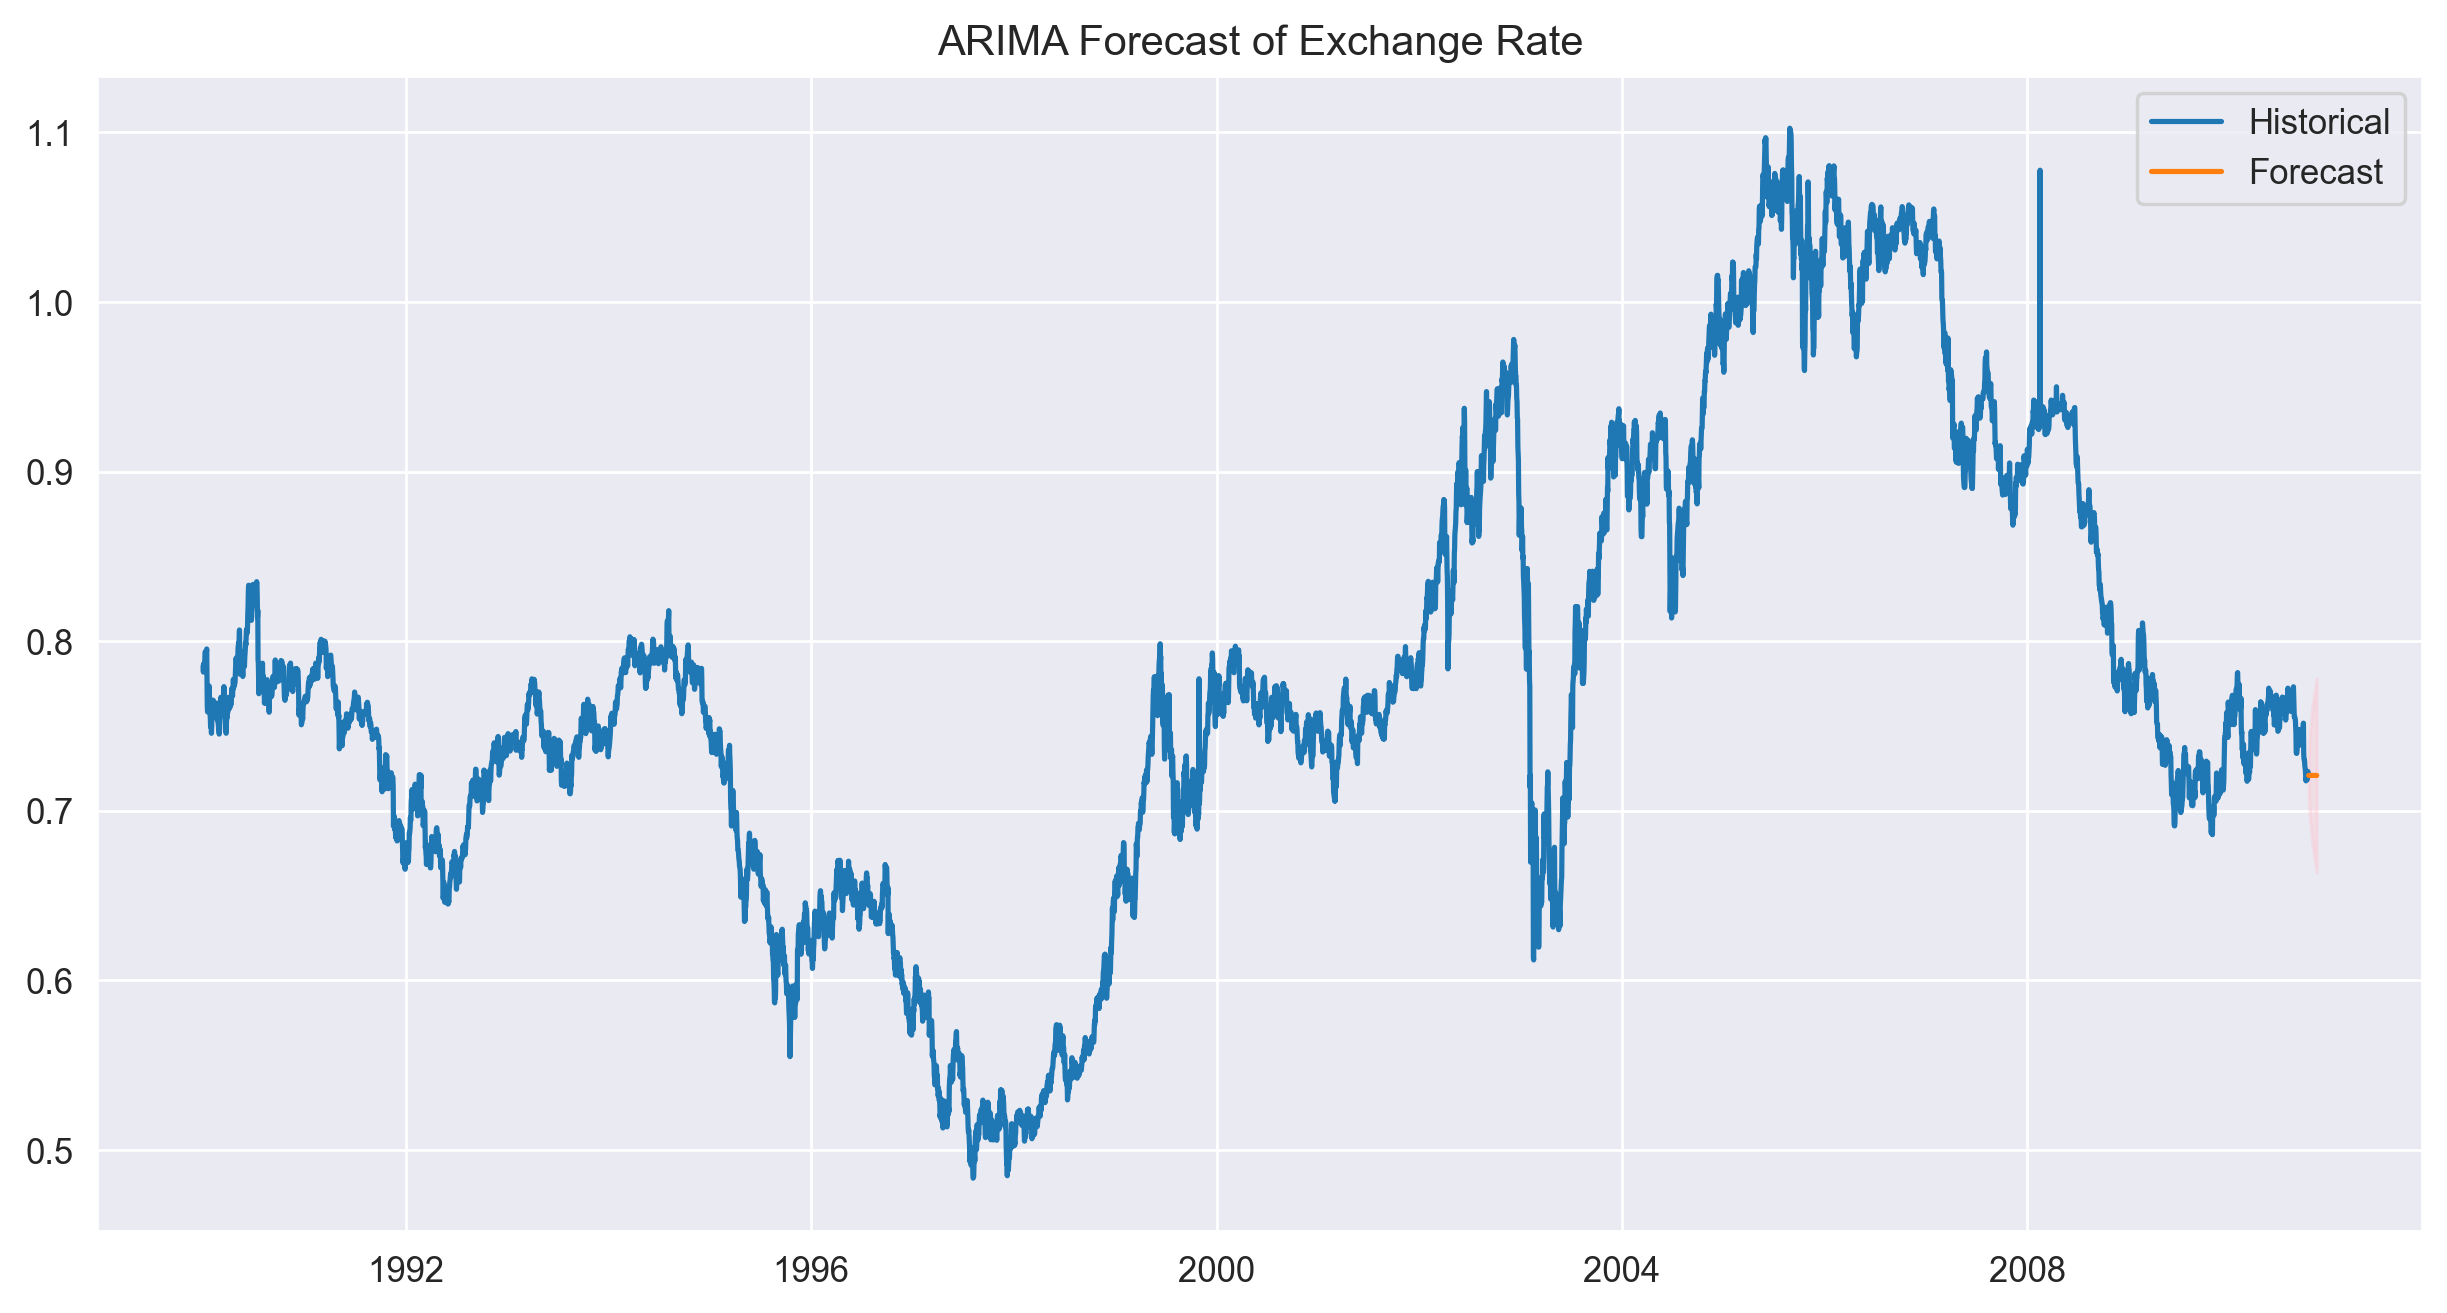

In [48]:
# Forecasting the next 30 days
forecast_arima = result_arima.get_forecast(steps=30)
forecast_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=30, freq='D')
forecast_values = forecast_arima.predicted_mean
conf_int = forecast_arima.conf_int()

# Plot the forecast
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Ex_rate'], label='Historical')
plt.plot(forecast_index, forecast_values, label='Forecast')
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('ARIMA Forecast of Exchange Rate')
plt.legend()
plt.show()


We forecasted the next 30 days using the ARIMA model and plotted the predictions along with the confidence intervals.

# Model Building – Exponential Smoothing

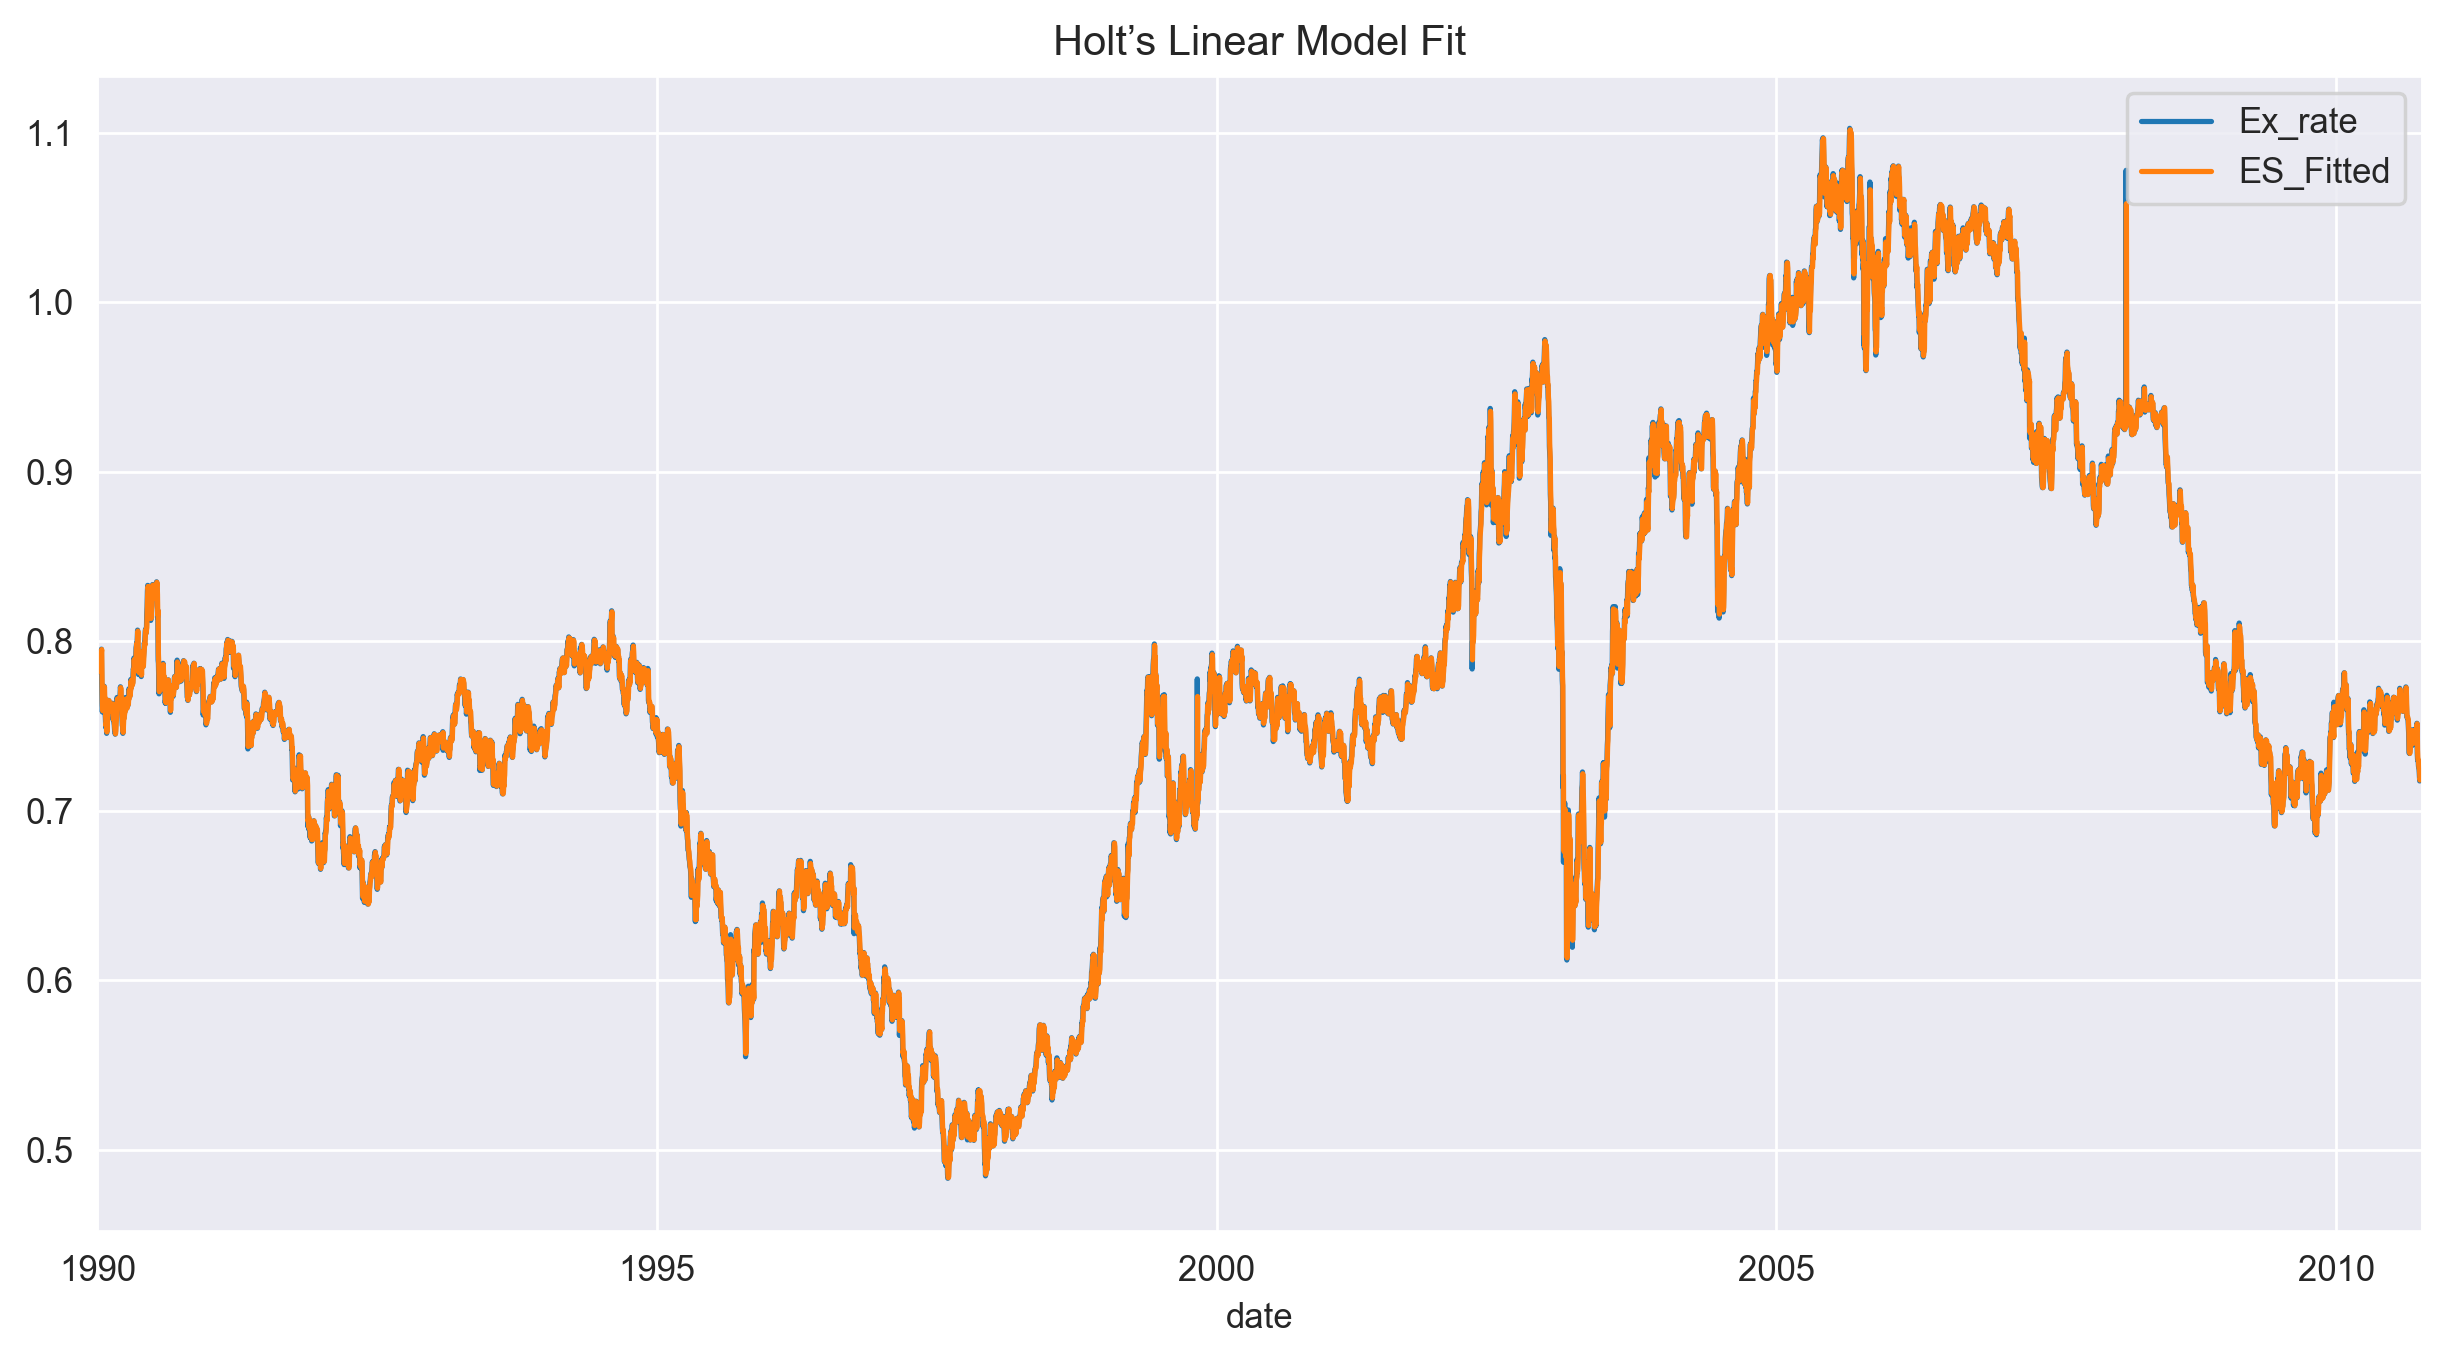

In [51]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Holt’s Linear Model
model_es = ExponentialSmoothing(df['Ex_rate'], trend='add', seasonal=None)
result_es = model_es.fit()

# Plot fitted values
df['ES_Fitted'] = result_es.fittedvalues
df[['Ex_rate', 'ES_Fitted']].plot(figsize=(12,6), title="Holt’s Linear Model Fit")
plt.show()


We selected Holt’s Linear model since there is a trend in the data. The fitted values help us compare how well the model follows the historical data.

# forcasting

<Figure size 3000x1500 with 0 Axes>

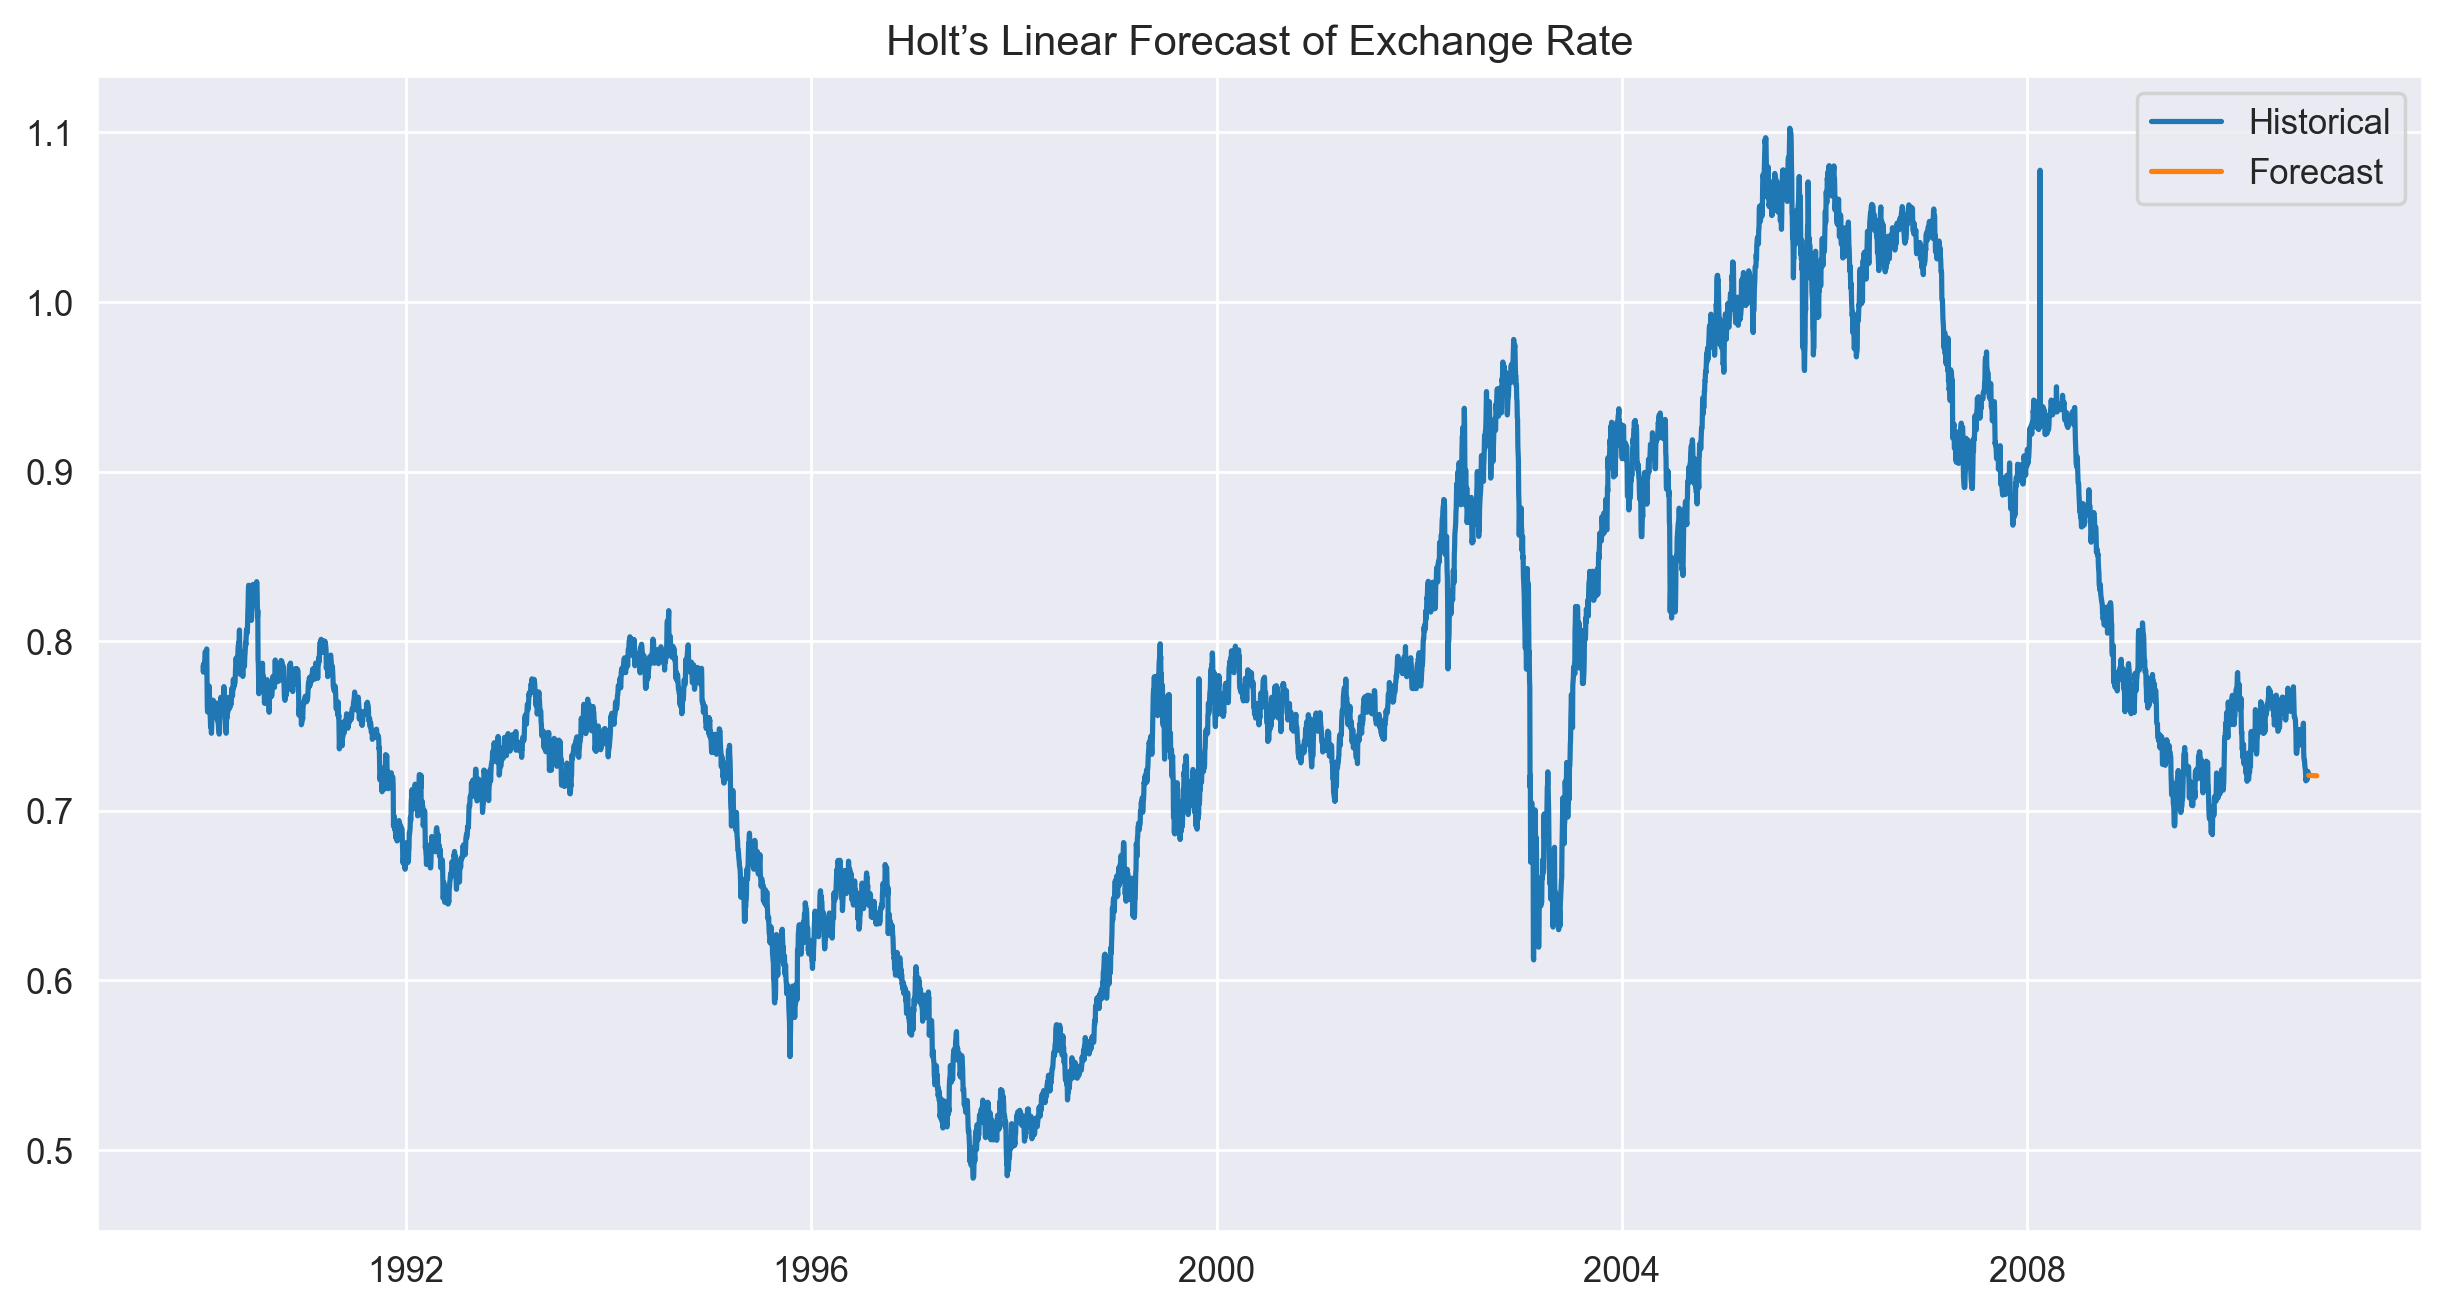

In [53]:
# Forecast the next 30 days
forecast_es = result_es.forecast(steps=30)
forecast_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=30, freq='D')

# Plot the forecast
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Ex_rate'], label='Historical')
plt.plot(forecast_index, forecast_es, label='Forecast')
plt.title('Holt’s Linear Forecast of Exchange Rate')
plt.legend()
plt.show()


The model forecasted future values which are plotted along with the historical data to visually assess the fit.

# Evaluation and Comparison

In [58]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ARIMA metrics
mae_arima = mean_absolute_error(df['Ex_rate'], result_arima.fittedvalues)
mse_arima = mean_squared_error(df['Ex_rate'], result_arima.fittedvalues)
rmse_arima = np.sqrt(mse_arima)

# Exponential Smoothing metrics
mae_es = mean_absolute_error(df['Ex_rate'], result_es.fittedvalues)
mse_es = mean_squared_error(df['Ex_rate'], result_es.fittedvalues)
rmse_es = np.sqrt(mse_es)

print(f"ARIMA MAE: {mae_arima:.4f}, RMSE: {rmse_arima:.4f}")
print(f"Exponential Smoothing MAE: {mae_es:.4f}, RMSE: {rmse_es:.4f}")


ARIMA MAE: 0.0038, RMSE: 0.0108
Exponential Smoothing MAE: 0.0037, RMSE: 0.0060


We calculated MAE and RMSE for both models to quantitatively compare their performance. Lower values indicate better predictions.

# MAPE CALCULATION

In [60]:
def mape(y_true, y_pred):
    return (abs(y_true - y_pred) / y_true).mean() * 100

mape_arima = mape(df['Ex_rate'], result_arima.fittedvalues)
mape_es = mape(df['Ex_rate'], result_es.fittedvalues)

print(f"ARIMA MAPE: {mape_arima:.2f}%")
print(f"Exponential Smoothing MAPE: {mape_es:.2f}%")


ARIMA MAPE: 0.50%
Exponential Smoothing MAPE: 0.48%


MAPE expresses forecast accuracy as a percentage, helping interpret model errors more intuitively.

# Plotting Actual vs Forecasted Values

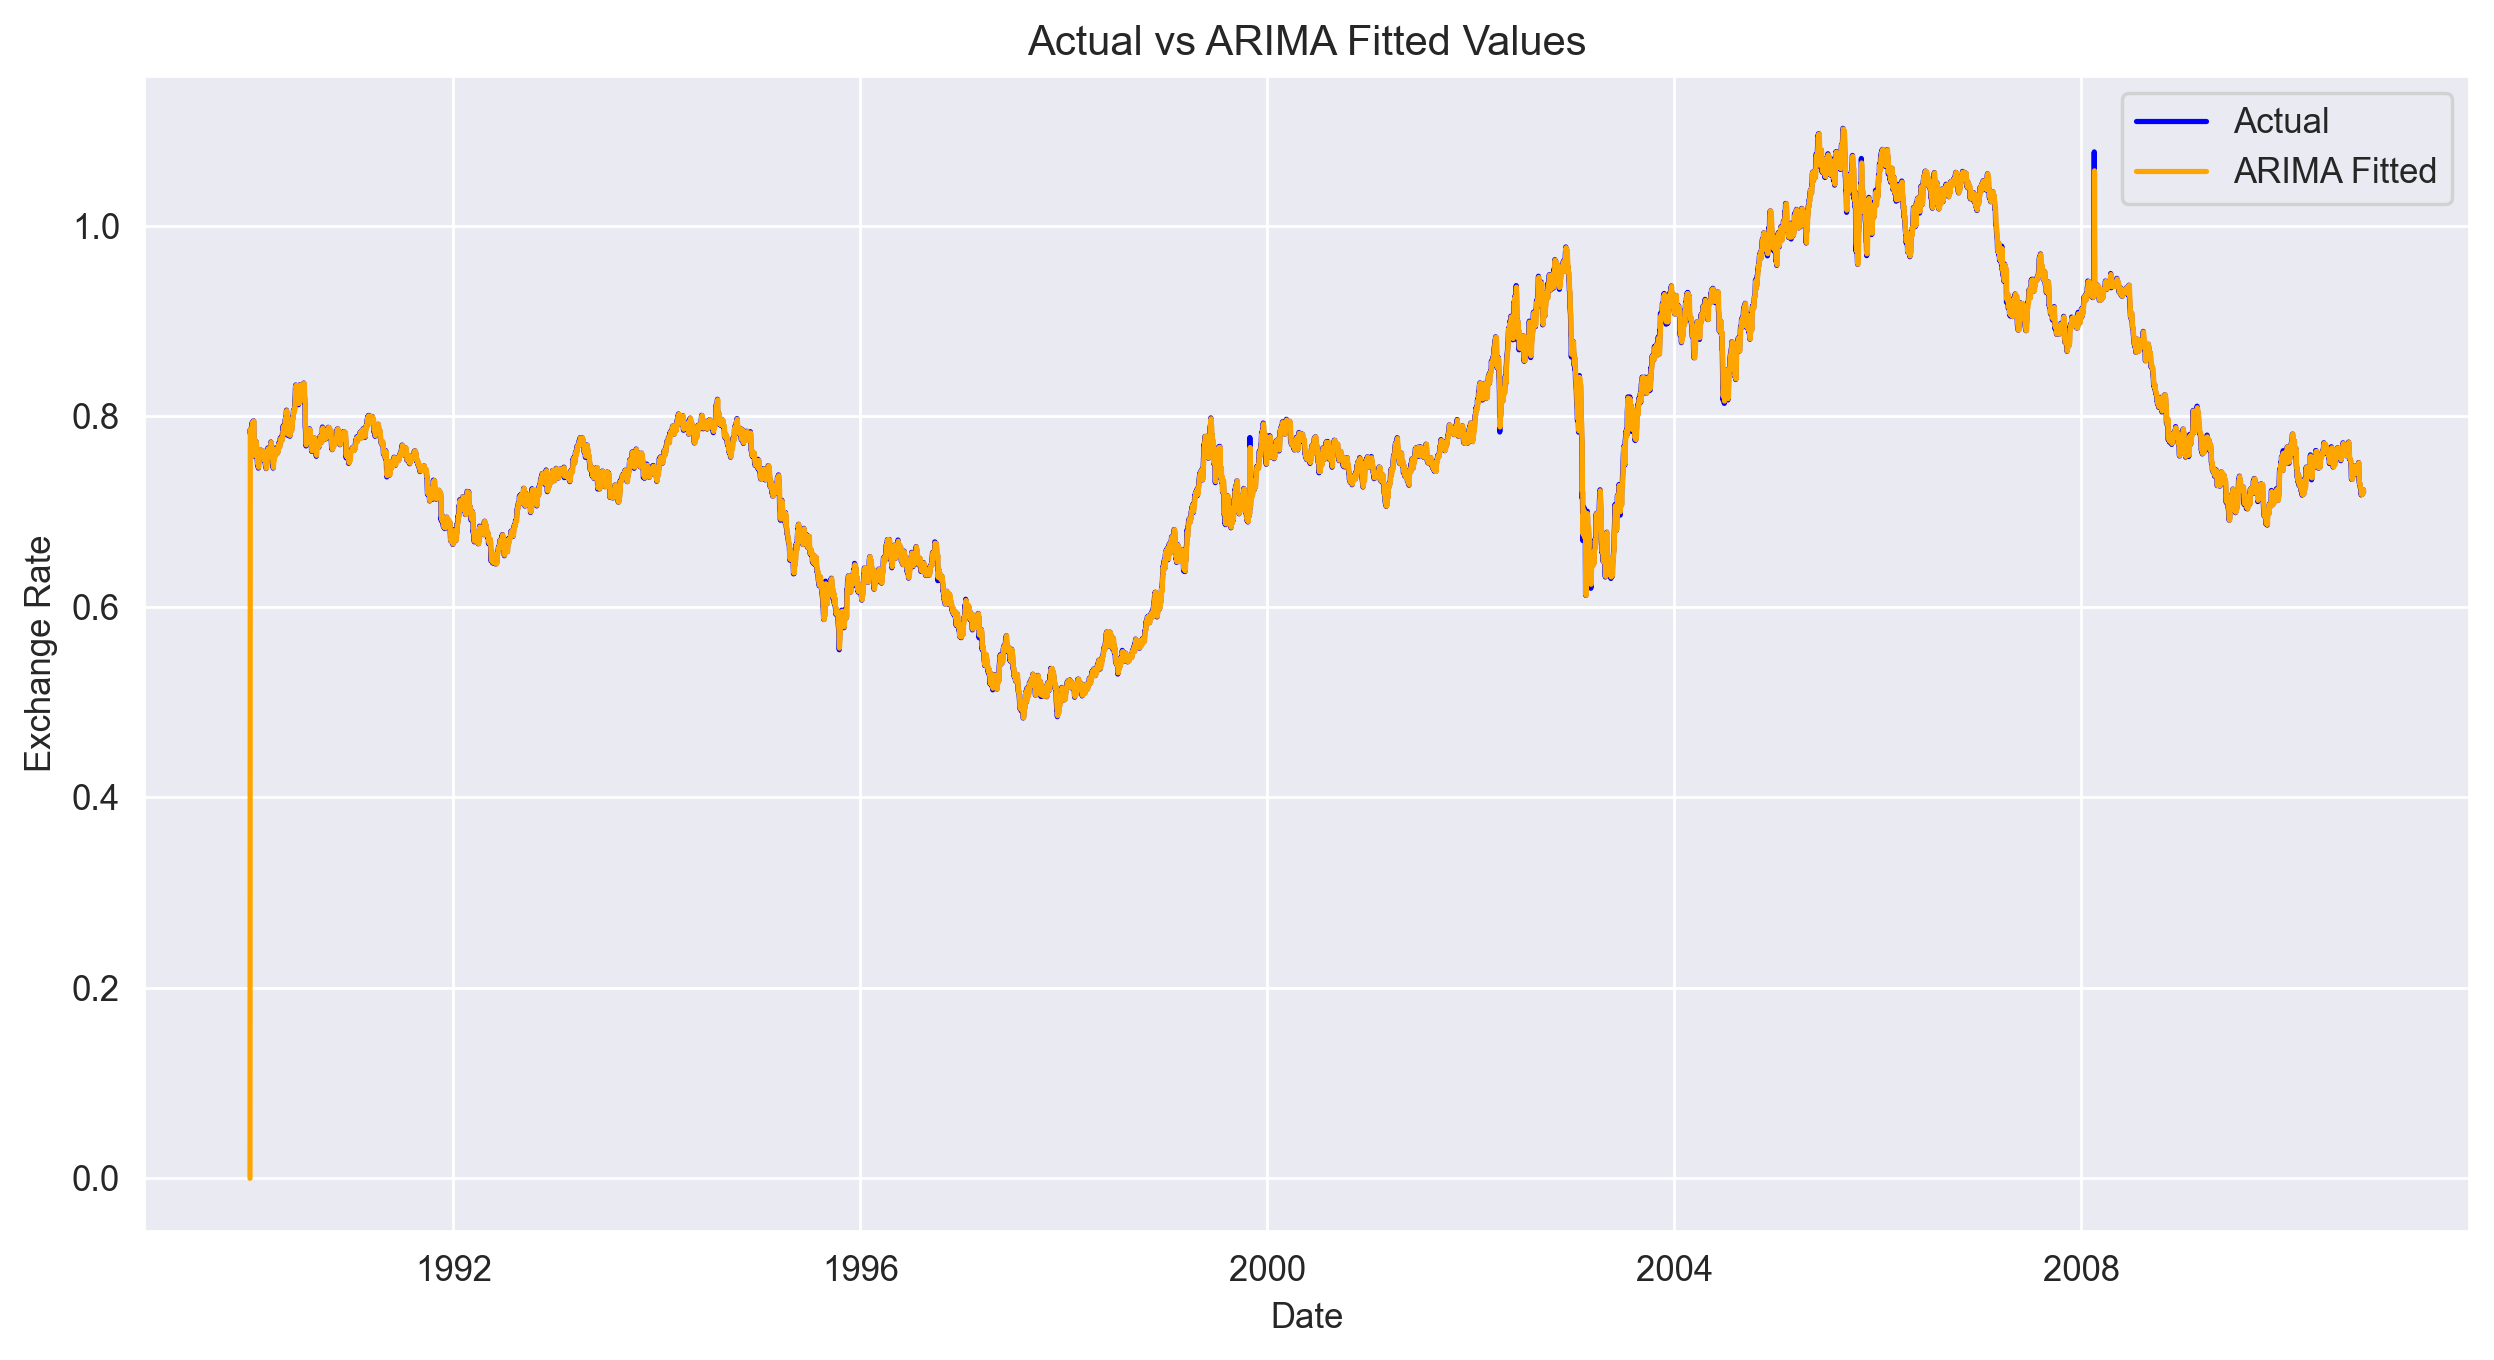

In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(df.index, df['Ex_rate'], label='Actual', color='blue')
plt.plot(result_arima.fittedvalues.index, result_arima.fittedvalues, label='ARIMA Fitted', color='orange')
plt.title('Actual vs ARIMA Fitted Values')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()


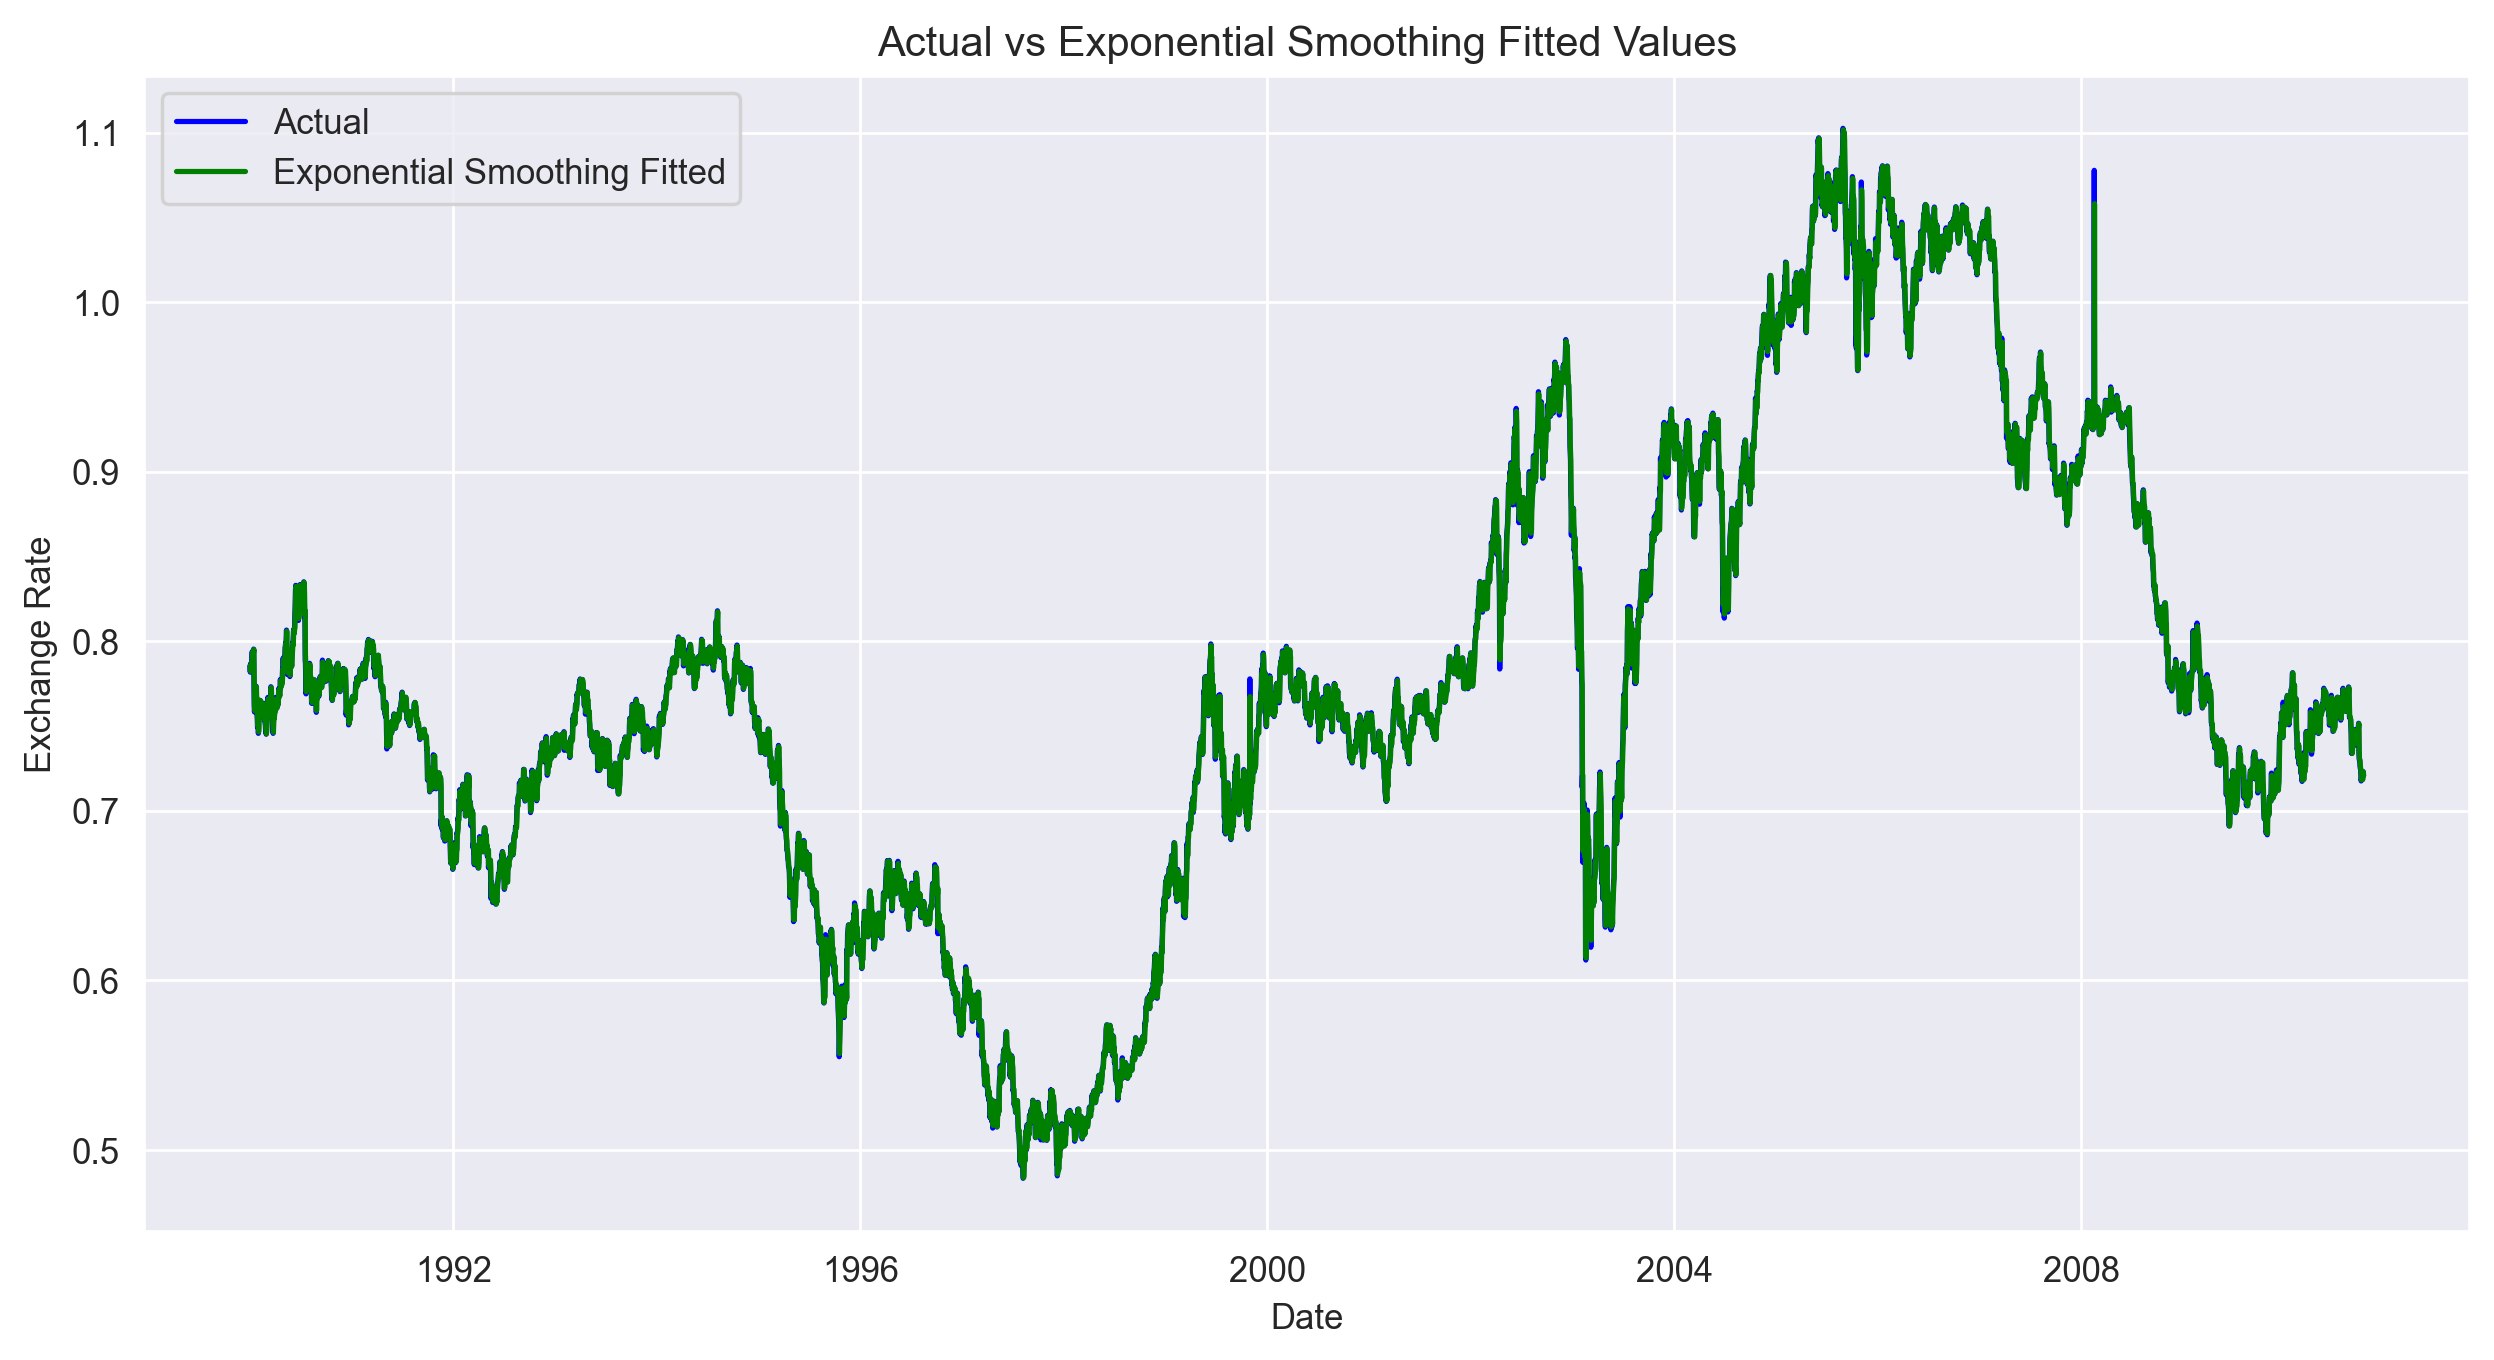

In [62]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Ex_rate'], label='Actual', color='blue')
plt.plot(result_es.fittedvalues.index, result_es.fittedvalues, label='Exponential Smoothing Fitted', color='green')
plt.title('Actual vs Exponential Smoothing Fitted Values')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()


# Key Findings

The ARIMA model achieved a Mean Absolute Error (MAE) of 0.0038, a Root Mean Squared Error (RMSE) of 0.0108, and a Mean Absolute Percentage Error (MAPE) of 0.50%.

The Exponential Smoothing model outperformed ARIMA slightly with a MAE of 0.0037, RMSE of 0.0060, and MAPE of 0.48%.

Both models produced forecasts that closely followed the historical exchange rate data, with minimal deviation and excellent predictive power.



# conclusion

The analysis confirms that both models are highly suitable for forecasting exchange rates in this dataset. The Exponential Smoothing model showed a slight edge, particularly in terms of RMSE and MAPE, indicating that it better manages variations without producing significant errors.

ARIMA is a powerful tool for datasets with temporal dependencies and when stationarity is a concern.

Exponential Smoothing provides robustness and simplicity, performing exceptionally well for stable data patterns like exchange rates.

Given the negligible difference between the two, either model can be confidently used. However, based on the error metrics, Exponential Smoothing is recommended for its slightly better accuracy and ease of application.

This comprehensive analysis demonstrates how statistical models can effectively forecast financial time series, offering actionable insights for decision-making in economic planning and investments.